# <center>IMPLEMENT MEDICAL IMAGE SEGMENTATION  BASED ON **UNET** </center>

---



# 1.  Introduction

Medical image segmentation is a crucial and challenging task in the field of medical image analysis, involving the identification and separation of areas of interest such as tumors and organs from the rest of the image in CT or MRI scans. However, accessing these images can be difficult due to privacy concerns, and this task requires high accuracy and efficiency.

UNet is a widely-used deep learning architecture for medical image segmentation, with demonstrated potential in segmenting small samples of high-precision medical images. In this project, we have implemented several Transformer-based UNets alongside UNet for the segmentation of the small bowel, large bowel, and stomach in medical images. These Transformer-based UNets utilize self-attention mechanisms to capture both global and local dependencies within the image, thereby improving segmentation performance.

The goal of this project is to compare the performance of different UNet architectures on a dataset of medical images, with an emphasis on analyzing the effectiveness of using self-attention mechanisms for segmenting the small bowel, large bowel, and stomach. The dataset used in this project is the UWMGI dataset. Each of these models has been trained and evaluated assess their segmentation accuracy and effectiveness. The results of this study can have significant implications for medical professionals and researchers, as accurate and efficient segmentation of medical images is critical for making informed diagnoses and treatment decisions.



# Preliminaries

In [ ]:
#@title GPU & RAM Checking
!nvidia-smi

Sun Mar 26 16:52:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Package Installation
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"yincelia","key":"690184a99e304d046e8a7aa728d06f09"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/uwmgi-mask-dataset -p '/content' --force
# !kaggle competitions download -c uw-madison-gi-tract-image-segmentation --force
!unzip -n './uwmgi-mask-dataset.zip' -d './uwmgi mask'
# !unzip -n './uw-madison-gi-tract-image-segmentation.zip' -d './uwmgi data'

In [ ]:
# !pip install plotly
# !pip install albumentations
# !pip install colorama
!pip install torchsummary 
!pip install timm
!pip install rasterio
!pip install colorama
!pip install einops
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -q scikit-learn==1.0

In [ ]:
###### Google drive #####
### Stores pre-stored model pth file and others
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###### Wandb ######
### Track, compare, and visualize experiments
# Log in to my W&B account
import wandb
wandb.login(key='698a6dab6adc93f20552543ace49093de53e58a0')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Here we are using WanDB which is a platform for real-time monitoring of model performance and evaluation of various metrics.

# Import Libraries

In [ ]:
'''
############################
Import Libraries
############################
'''

# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torchsummary import summary

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Training/Testing Options
In order to facilitate the training of different models with varying parameters, we have constructed an Option class here to store the model configurations.

In [ ]:
'''
opt = Options()
'''
class Options:
    def __init__(self):
        # Random Seed
        self.seed = 1027
        
        # Debugging
        self.debug = False
        
        # Experiment Details
        self.exp_name = 'Baselinev2'
        self.comment = 'unet-efficientnet_b1-224x224-aug2-split2'
        
        # Model Settings
        self.model_name = 'Unet'    # or 'LeVitUnet' 'TransformerUnet' 'SwinUnet'
        self.backbone = 'efficientnet-b1'   # or ''
        self.num_classes = 3    # only 3 classes for this UW dataset: ['large_bowel', 'small_bowel', 'stomach']
        
        # Image Settings
        self.img_size = [224, 224]  # [256,256] for SwinUnet
        
        # Training Settings
        self.train_bs = 128     # batch size 64 32 better for SwinUnet
        self.valid_bs = self.train_bs * 2
        self.epochs = 30
        # self.warmup = True
        self.warmup_epochs = 3  # warm up settings
        self.lr_init = 1e-4
        self.lr = 2e-3
        self.scheduler = 'CosineAnnealingLR' # 'CosineAnnealingWarmRestarts' 'StepLR' 'ReduceLROnPlateau' 'ExponentialLR' 'OneCycleLR' 'CyclicLR'
        self.min_lr = 1e-6
        self.T_max = int(30000 / self.train_bs * self.epochs) + 50
        self.T_0 = 25
        self.train_criterion = 'BceTversky' #'CrossEntropy'#
        self.wd = 1e-6
        self.n_accumulate = max(1, 32 // self.train_bs)
        self.n_fold = 5
        
        # Device Settings
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# init options
opt = Options()

In [ ]:
'''
############################
Set Seed for the entire project -> Reproducible
############################
'''

def set_seed(seed = 1027):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'SEED = {seed} DONE')
    
set_seed(opt.seed)

SEED = 1027 DONE


In [ ]:
'''
############################
Paths -> store the model's file on Google Drive
############################
'''

# Project and Data Dir
PROJ_PATH = '/content/drive/MyDrive/MSIN0097 Project'
DATA_PATH = './uwmgi data'
MASK_PATH = './uwmgi mask'

# Model Logging Dir
MODEL_PATH = '/content/drive/MyDrive/MSIN0097 Project/model_log'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)


# Dataset Acquisition and Exploration Analysis


The dataset comes from UW-Madison Carbone Cancer Center. This dataset mainly contains the MRI scans, which are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. Our task now is to utilze nureal network to automatically segment the stomach and intestines on MRI scans. 

Besides those MRI images, a .csv file is also provides information about the image and corresponding masks. 

The mask annotations are provided as RLE-encoded format, and the images are in 16-bit, grayscale, PNG format.

Let's dive into the train.csv dataset first.

## Data Exploration - *train.csv*

In [71]:
####### dataset .csv file #######
df = pd.read_csv(MASK_PATH + '/train.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  int64 
 4   day           115488 non-null  int64 
 5   slice         115488 non-null  int64 
 6   image_path    115488 non-null  object
 7   height        115488 non-null  int64 
 8   width         115488 non-null  int64 
 9   mask_path     115488 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.8+ MB


id        class segmentation  case  day  slice  \
0  case123_day20_slice_0001  large_bowel          NaN   123   20      1   
1  case123_day20_slice_0001  small_bowel          NaN   123   20      1   
2  case123_day20_slice_0001      stomach          NaN   123   20      1   

                                          image_path  height  width  \
0  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
1  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   
2  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   

                                           mask_path  
0  /kaggle/input/uwmgi-mask-dataset/png//uw-madis...  
1  /kaggle/input/uwmgi-mask-dataset/png//uw-madis...  
2  /kaggle/input/uwmgi-mask-dataset/png//uw-madis...

**DATAFRAME OVERVIEW**

In [72]:
# Count number of unique values for each column
df.nunique()

id              38496
class               3
segmentation    33899
case               85
day                35
slice             144
image_path      38496
height              4
width               4
mask_path       38496
dtype: int64

In [73]:
# The class widthin the train.csv file has 3 distinct values: large bowel, small bowel, stomach. 
CLASS = df['class'].unique()
list(CLASS)

['large_bowel', 'small_bowel', 'stomach']

In [74]:
# Show a row that without null value
no_null = df.dropna().head(1)
no_null

id    class  \
194  case123_day20_slice_0065  stomach   

                                          segmentation  case  day  slice  \
194  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...   123   20     65   

                                            image_path  height  width  \
194  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   

                                             mask_path  
194  /kaggle/input/uwmgi-mask-dataset/png//uw-madis...

**INVESTIGATE THE OCCURENCE SEGMENTATION MAP TYPES**

In [ ]:
df_class = df.dropna(subset = ['segmentation']).groupby('class')['id'].count()
df_class = df_class.reset_index()
df_class
fig = px.bar(df_class, x='id', y='class', color='class', orientation='h',color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(title_text='<b>Mask Class Count (without Null)</b>',
                  xaxis_title='Count',
                  yaxis_title='Class',
                 height = 300,)
fig.show()

In [75]:
df_seg = df.groupby('id')['segmentation'].count().reset_index()['segmentation'].value_counts().reset_index()
df_seg = df_seg.sort_values(by=['index'])
# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=df_seg['index'], values=df_seg['segmentation'], hole=.4)])
fig.update_layout(title_text='<b>Number of Segmentation Masks per Image  (label 0-3 means 0-3 masks)</b>',height=400)
fig.show()

In [ ]:
df_stack=df.groupby('id')['segmentation'].count().reset_index().merge(df.dropna(subset = ['segmentation'])[['id', 'class']]).reset_index()
# df_stack.groupby('segmentation').count().reset_index()
fig = px.bar(df_stack, x='id', y='segmentation', color='class', orientation='h', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(title_text='Mask Class Count (without Null)',
                  xaxis_title='Count',
                  yaxis_title='Class',
                 height = 400)
fig.show()

**INVESTIGATE THE IMAGE SIZES**

In [76]:
fig = px.scatter(df.drop_duplicates(subset=["width", "height"]), x="width", y="height", 
                 size=df.groupby(["width", "height"])["id"].transform("count").iloc[df.drop_duplicates(subset=["width", "height"]).index], 
                 color="("+df.drop_duplicates(subset=["width", "height"])["width"].astype(str)+","+df.drop_duplicates(subset=["width", "height"])["height"].astype(str)+")", 
                 title="<b>Bubble Chart Showing The Various Image Sizes</b>",
                 labels={"color":"<b>Size Legend</b>", 
                         "size":"<b>Number Of Observations</b>",
                         "height":"<b>Image Slice Height (pixels)</b>",
                         "width":"<b>Image Slice Width (pixels)</b>"},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 size_max=160)
fig.show()

**INVESTIGATE CASE IDS**

In [77]:
fig = px.histogram(df, df.case.astype(str), color="day", title="<b>Distribution Of Images Per Case ID</b>", 
             labels={"x":"<b>Case ID</b>", "day_num_str": "<b>The Day The Scan Took Place</b>"}, text_auto=True, width=1800,
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

**PREPARING FOR IMAGES & MASKS VISUALISATION**

In [78]:
###### First we change datapath in df ######
# Show data paths in .csv
print('Sample Image path: \n'+df.image_path[0])
print('Sample Mask path: \n'+df.mask_path[0])

Sample Image path: 
/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
Sample Mask path: 
/kaggle/input/uwmgi-mask-dataset/png//uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png


In [79]:
# Modify the data path in original csv file
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['image_path'] = df.image_path.str.replace('/kaggle/input/uw-madison-gi-tract-image-segmentation', DATA_PATH)
df['mask_path'] = df.mask_path.str.replace('/kaggle/input/uwmgi-mask-dataset', MASK_PATH).str.replace('/png/','/np').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each image

df = df.drop(columns=['segmentation', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head(1)

id        class  case  day  slice  \
0  case123_day20_slice_0001  large_bowel   123   20      1   

                                          image_path  height  width  \
0  ./uwmgi data/train/case123/case123_day20/scans...     266    266   

                                           mask_path segmentation  rle_len  \
0  ./uwmgi mask/np/uw-madison-gi-tract-image-segm...       [, , ]        0   

   empty  
0   True

In [80]:
print('New Image path: \n'+df.image_path[0])
print('New Mask path: \n'+df.mask_path[0])

New Image path: 
./uwmgi data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
New Mask path: 
./uwmgi mask/np/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.npy


In [81]:
fig = df['empty'].value_counts().plot.bar(orientation='h', color_discrete_sequence=px.colors.qualitative.Pastel)

# fig = px.bar(df, x=, y='class', color='class', orientation='h',color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(title_text='<b>Empty Mask Count</b>',
                  xaxis_title='Count',
                  yaxis_title='Empty',
                 height = 300,)
fig.show()

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38496 entries, 0 to 38495
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            38496 non-null  object
 1   class         38496 non-null  object
 2   case          38496 non-null  int64 
 3   day           38496 non-null  int64 
 4   slice         38496 non-null  int64 
 5   image_path    38496 non-null  object
 6   height        38496 non-null  int64 
 7   width         38496 non-null  int64 
 8   mask_path     38496 non-null  object
 9   segmentation  38496 non-null  object
 10  rle_len       38496 non-null  int64 
 11  empty         38496 non-null  bool  
dtypes: bool(1), int64(6), object(5)
memory usage: 4.6+ MB


This is our final dataset after filtering, which will be used to guide the input of the model. The dataset contains a total of **38,496** examples.

## Dataset Sample Visualisation

### What does computer see?

> Before introducing our methods to do image segmentation task, there is one thing
that needs to be illustrated ---- for Computer Vision, what the computer sees? Is it the same for human beings to see a colorful picture?

>> *Computer stores the image in digital form.*

> If we keep zooming in on the image, we can observe that the image becomes distorted, and we see small boxes on the image called Pixels. Each of these pixels is represented as a value and these numbers are called pixel values. These pixel values represent the intensity of the pixel. For grayscale or black and white images, we have pixel values ranging from 0 to 255. Every image in the computer is saved in this form, which forms a matrix of numbers, which is also called Channel. For grayscale images, there is only one channel; for color images, there are three channels: red(R), green(G), blue(B) channels, since every color image is composed of these three colors.



**SINGLE IMAGE EXAMPLE WITH MASK**




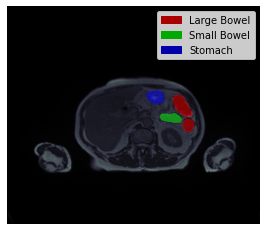

In [ ]:
# Plot Just ONE image with transparent mask 
# Read image
path = DATA_PATH + '/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = load_grey_img(path)

# Get mask
m_path = MASK_PATH+'/np/uw-madison-gi-tract-image-segmentation/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.npy'
mask = load_msk(m_path)

show_img(img, mask)

We have standardized the annotation format for the masks of each image throughout the entire project. The color *red* for the large bowel, *green* for small bowel, and *blue* for stomach.

**A GROUP OF IMAGE EXAMPLEs OF ONE CASE**




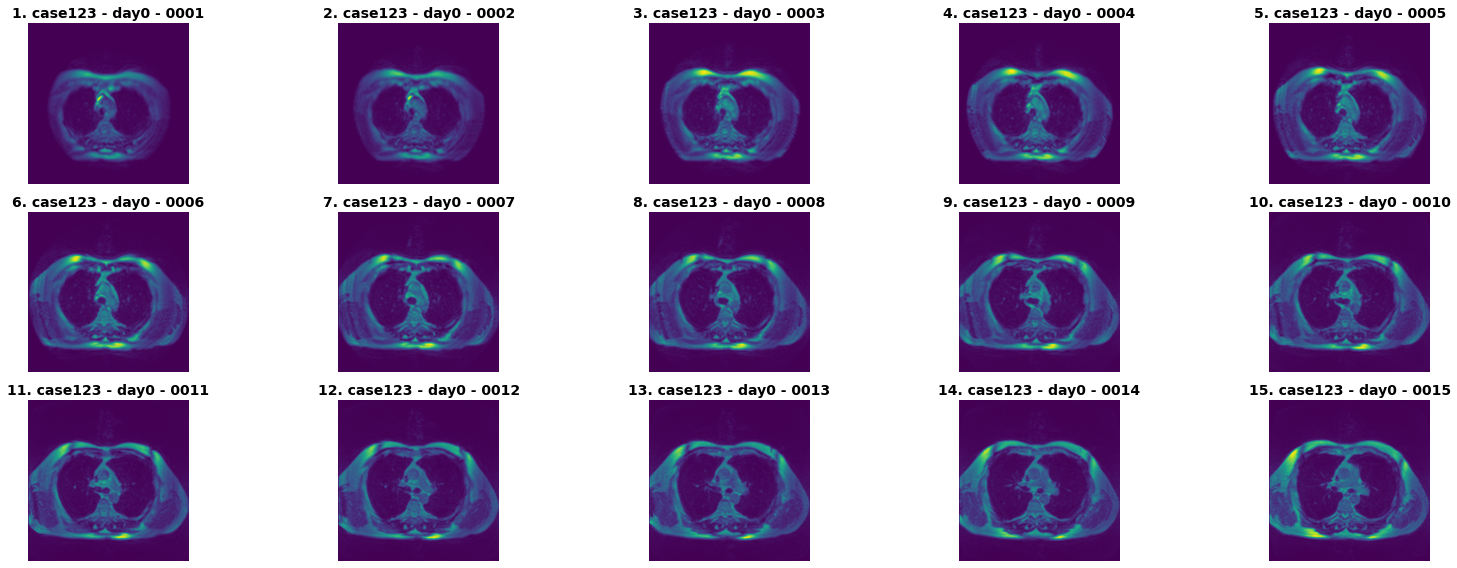

In [ ]:
# Show Original Images for a specific day / case

CASE = 123
train = df.copy()
# Sample a few images from speciffied case
sample_paths1 = train[(train["segmentation"].isna()==False) & (train["case"]==CASE)]["image_path"]\
                .reset_index().groupby("image_path")["index"].count()\
                .reset_index().loc[:14, "image_path"].tolist()

show_simple_images(sample_paths1, image_names="case123_samples")

**A GROUP OF IMAGE EXAMPLEs WITH MASK OF ONE CASE**




In [ ]:
# Show images with masks on a case/ day
case = 123
day= 20

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
data = df[(df["case"]==case) & (df["day"]==day)].drop_duplicates("image_path").reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in data["image_path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in data["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=data["id"].tolist(), alpha=0.7)

KeyError: ignored

**MASK HAETMAP OF CLASSES**

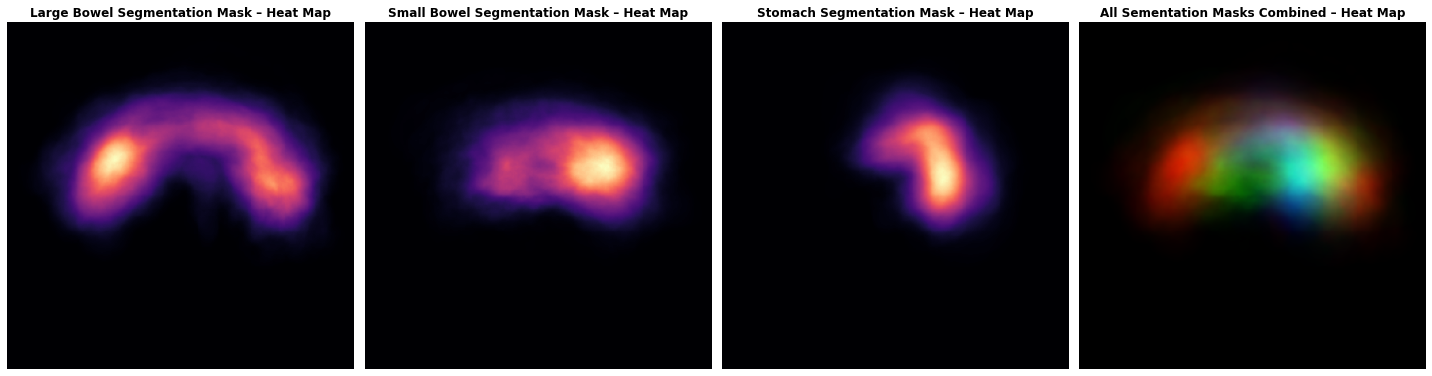

In [ ]:
'''
Mask Heatmap
'''
heatmap = np.zeros((256,256,3), dtype=np.float32)

for subdir, dirs, files in os.walk(MASK_PATH):
    for file in files:
        if file.endswith(".npy"):
            file_path = os.path.join(subdir, file)
            _mask = cv2.resize(np.load(file_path), (256,256), interpolation=cv2.INTER_NEAREST)
            heatmap+=_mask

heatmap=heatmap/heatmap.max()

plt.figure(figsize=(20,12))

plt.subplot(1,4,1)
plt.imshow(heatmap[..., 0], cmap="magma")
plt.title("Large Bowel Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,2)
plt.imshow(heatmap[..., 1], cmap="magma")
plt.title("Small Bowel Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,3)
plt.imshow(heatmap[..., 2], cmap="magma")
plt.title("Stomach Segmentation Mask – Heat Map", fontweight="bold")
plt.axis(False)

plt.subplot(1,4,4)
plt.imshow(heatmap)
plt.title("All Sementation Masks Combined – Heat Map", fontweight="bold")
plt.axis(False)

plt.tight_layout()
plt.show()

Above mask heatmaps of 4 classes visually represent the areas in an image that are associated with each class. This can be particularly useful in our semantic segmentation task, where the goal is to identify and label different objects or regions within an image. 

These mask heatmaps indicate which parts of the image correspond to each class, allowing us to better understand the results of the model and identify areas for improvement. From the fourth image, we can see that all four classes are concentrated in the upper-middle part of the image, while the shape of the class "large intestine" is more prominent, presenting a parabolic shape that opens downwards.



---



# **Utility Functions**

Functions supporting this project.

### Image Manipulation

In this module, we have implemented basic functions for image manipulation and visualisation, including processing of three-dimensional RGB and one-dimensional grayscale images, as well as handling of segmentation masks encoded in RLE format provided in the train.csv file. 

In [ ]:
'''
############################
Image Converts
Includes functions: ID to Mask (in df), rgb to gray, gray to rgb
############################
'''

'''
Returns a mask for each case ID. 
If no segmentation was found, the mask will be empty, meaning formed by only 0
id: the case ID from the train.csv file
verbose: True if we want any prints
return: segmentation mask
'''
def get_id_mask(id, verbose=False):

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==id].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data.loc[k, :] for k in range(3)]


    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = np.max([obs.height for obs in observations])
    max_width = np.max([obs.width for obs in observations])

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = observations[k]
            segmentation = observation.segmentation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

    # If no segmentation was found skip
    elif max_segmentation == 0:
        mask = None
        if verbose:
            print("None of the classes have segmentation.")
            
    return mask

def id2mask(id, df, class_list, rle_decode_func):
    idf = df[df['id']==id]
    wh = (idf['height'].iloc[0], idf['width'].iloc[0])
    shape = (*wh, 3)
    # print(shape)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, cls in enumerate(class_list):
        df_ = idf[idf['class']==cls]
        rle = df_['segmentation'].squeeze()
        if len(df_) and not pd.isna(rle):
            # don't know the number of dimensions of mask beforehand
            mask[..., i] = rle_decode_func(rle, wh)
    return mask


def rgb2gray(mask):
    # Add a zero channel to the mask array to represent the gray channel
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)], mode='constant', constant_values=0)
    # Find the channel with the maximum value for each pixel
    gray_mask = np.argmax(pad_mask, axis=-1)
    return gray_mask

    # pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    # gray_mask = pad_mask.argmax(-1)
    # return gray_mask

def gray2rgb(mask):
    # Convert the grayscale mask to one-hot encoding with 4 classes
    rgb_mask = tf.one_hot(mask, depth=4)
    # Discard the first channel, which corresponds to the background class, and convert to the original dtype
    rgb_mask = tf.cast(rgb_mask[..., 1:], dtype=mask.dtype)
    return rgb_mask

    # rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    # return rgb_mask[..., 1:].astype(mask.dtype)

In [ ]:
'''
############################
Image Loads
############################
'''
def read_image(path):
    '''Reads and converts the image.
    path: the full complete path to the .png file'''

    # Read image in a corresponding manner
    # convert int16 -> float32
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    # Scale to [0, 255]
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    
    return image
    
def load_rgb_img(path):
    if os.path.exists(path) == False:
        print("\nFile does not exist: " + path)
        return None
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # print('\nDDDDDDD'+str(img.shape))

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    # print('\nEEEEEEEE'+str(img.shape))
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    # print('\nGGGGGGGG'+str(img.shape))
    return img

def load_grey_img(path):
    if os.path.exists(path) == False:
        print("\nFile does not exist: " + path)
        return None
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.expand_dims(img, axis=2)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32') / 255.0
    return msk
    
# Show image together with mask and legend for each class
def show_img(img, mask=None):
    # Apply CLAHE on the input image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # Plot the mask with transparency on the input image
        plt.imshow(mask, alpha=0.5)
        # Set colors for legends
        handles = [Rectangle((0,0),1,1, color=c) for c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')


In [ ]:
'''
############################
RLE processing
RLE is used in the segmentation cloumn to show the mask image. 
############################
'''
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
'''
############################
Image Presenting
############################
'''
def show_simple_images(sample_paths, image_names="sample_images"):
    '''Displays simple images (without mask).'''

    # Get additional info from the path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]


    # Plot
    fig, axs = plt.subplots(3, 5, figsize=(23, 8))
    axs = axs.flatten()

    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, 
                         weight='bold')

        img = read_image(path)
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()


def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    my_colors = ["#CC5547", "#DB905D", "#D9AE6C", "#93AF5C", "#799042", "#61783F"]

    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

### K-Fold Cross-Validation

Below code implements a cross-validation strategy that ensures that samples with the same group value are kept together in the same fold, and that the same proportion of values in the 'empty' variable are present in each fold. This can be useful for ensuring that the model is robust to variations within different groups of data, such as different patients in a medical dataset.

In [ ]:
'''
K-fold Cross-Validation
Split the df into train and validation sets for a given number of folds, 
and assign a fold number to each row in the df based on its corresponding group
'''
def create_folds(df, n_splits, seed):
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    folds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups=df['case'])):
        df_fold = df.iloc[val_idx].copy()
        df_fold['fold'] = fold
        folds.append(df_fold)
    
    df_folds = pd.concat(folds, axis=0)
    return df_folds
    
df_folds = create_folds(df, n_splits=opt.n_fold, seed=opt.seed)
display(df_folds.groupby(['fold', 'empty'])['id'].count())

fold  empty
0     False    2917
      True     3931
1     False    3518
      True     4642
2     False    3168
      True     4256
3     False    2868
      True     3468
4     False    4119
      True     5609
Name: id, dtype: int64

In [ ]:
df_folds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38496 entries, 4896 to 38207
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            38496 non-null  object
 1   class         38496 non-null  object
 2   case          38496 non-null  int64 
 3   day           38496 non-null  int64 
 4   slice         38496 non-null  int64 
 5   image_path    38496 non-null  object
 6   height        38496 non-null  int64 
 7   width         38496 non-null  int64 
 8   mask_path     38496 non-null  object
 9   segmentation  38496 non-null  object
 10  rle_len       38496 non-null  int64 
 11  empty         38496 non-null  bool  
 12  fold          38496 non-null  int64 
dtypes: bool(1), int64(7), object(5)
memory usage: 3.9+ MB


### Image Augmentation
Medical image segmentation is constrained by the abundant availability of labeled training data. To overcome the limitation of limited data availability, data augmentation techniques are used to prevent over-fitting and enhance the ability of the model to generalize well on unseen data beyond the training set. Data augmentation plays a crucial role in constructing robust deep learning pipelines. In medical imaging, augmentations are applied equally to both the image and label, which helps create deformed versions of the training data.

Below codes defined a series of image augmentation techniques to the input image and mask. These include resizing the image to a specific size, randomly flipping the image horizontally, shifting, scaling, and rotating the image, applying either grid distortion or elastic transformation, and applying a coarse dropout technique. These techniques are applied with certain probability values specified as parameters.

In [83]:
'''
############################
Data Augmentation
############################
'''
def train_trans(opt_):
    trans = A.Compose([
        A.Resize(*opt_.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=opt_.img_size[0]//20, max_width=opt_.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0)
    
    return trans

def val_trans(opt_):
    trans = A.Compose([
        A.Resize(*opt_.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
    return trans


### Dataset and Data Loader

`MyLoaders` creates train and validation datasets from the given dataframe using the `MyDataset` class with the specified data augmentations and color format. It then creates train and validation data loaders with the specified batch sizes and number of workers.

In [ ]:
'''
############################
Dataset
############################
'''
class MyDataset(Dataset):
    def __init__(self, df, label=True, trans=None, rgb=True):
        self.df = df
        self.label = label
        self.img_paths = df['image_path'].tolist()
        self.msk_paths = df['mask_path'].tolist()
        self.trans = trans
        self.rgb = rgb
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        if self.rgb:
            img = load_rgb_img(img_path)
        else:
            img = load_grey_img(img_path)
        # print('\nCCCCCCC'+str(img.shape))
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            # print('\nAAAAAAAAA'+str(img.shape)+str(msk.shape))

            if self.trans != None:
                data  = self.trans(image = img, mask = msk)
                
                img = torch.from_numpy(data['image'].transpose((2, 0, 1)))
                msk = torch.from_numpy(data['mask'].transpose((2, 0, 1)))
            return img, msk
        else:
            if self.trans != None:
                img  = self.trans(image = img)
                img = torch.from_numpy(img['image'].transpose((2, 0, 1)))
            return img

In [ ]:
'''
############################
Data Loader with Augmentation
############################
'''
def MyLoaders(df, fold, opt_, sample=False, rgb=True):
    train_df = df[df["fold"] != fold].reset_index(drop=True)
    valid_df = df[df["fold"] == fold].reset_index(drop=True)
  
    if sample:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")

    train_dataset = MyDataset(train_df, trans=train_trans(opt_), rgb=rgb)
    valid_dataset = MyDataset(valid_df, trans=val_trans(opt_), rgb=rgb)

    train_loader = DataLoader(train_dataset, batch_size=opt_.train_bs if not sample else 32, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=opt_.valid_bs if not sample else 32, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader, train_dataset.__len__(), valid_dataset.__len__()


### Evaluate & Schedule

This code block defines several evaluation metrics used in project. The Dice similarity coefficient (DSC) is a widely used metric in evaluating the segmentation performance of the U-Net model. It measures the similarity between two segmentations. Additionally, sensitivity (SEN) and positive predictive value (PPV) have also been used as evaluation metrics.

In [ ]:
#@title Evaluation Metrics
'''
############################
Evaluation metrics & Loss functions
1. Dice similarity coefficient (DSC)
2. IOU
3. SEN
4. PPV
5. Cross Entropy
############################
'''
import segmentation_models_pytorch as smp

JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

###  Dice measures the overlap between the predicted and ground truth segmentation masks
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    '''
    # skip the batch and class axis for calculating Dice score
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>0.5).to(torch.float32)
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

### IOU/Jaccard loss measures the overlap between the predicted segmentation mask and
### the ground truth mask by calculating the ratio of the intersection area to the union area.
def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

### Cross Entropy Loss
# ce = nn.CrossEntropyLoss()
# def CrossEntropy(y_pred, y_true):
#     ce_loss = ce(y_pred, y_true)
#     return ce_loss

weights = torch.tensor([1.0, 5.0]).cuda()
import torch.nn.functional as F

def BceTversky(y_pred, y_true):
    bt_loss = 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
    return bt_loss

In [ ]:
#@title Scheduler with optimizer
'''
############################
Optimizers

Two are mainly used in this project:

CosineAnnealingLR gradually reduces the learning rate over a specified number of epochs using a cosine function. 
It helps to converge the model to a better optimum by gradually reducing the learning rate.

ReduceLROnPlateau monitors a specified metric (such as validation loss) and reduces the learning rate by a factor 
when the metric stops improving. This helps the model to fine-tune itself when the validation loss is no longer decreasing.
############################
'''
def fetch_scheduler(opt_, optimizer):
    if opt_.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=opt_.T_max, 
                                                   eta_min=opt_.min_lr)
    elif opt_.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=opt_.T_0, 
                                                             eta_min=opt_.min_lr)
    elif opt_.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='max',
                                                   factor=0.1,
                                                   patience=5,
                                                   threshold=0.0001,
                                                   min_lr=opt_.min_lr,)
    elif opt_.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif opt_.scheduler == None:
        return None
        
    return scheduler

### Training & Validation

In [ ]:
#@title Train one epoch
'''
Train one epoch function implemented with warm up strategy.
'''
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, opt_):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ', leave=True, position=0)

    # Warm-up settings
    if epoch < opt_.warmup_epochs+1:
        current_lr = opt_.lr * float(epoch) / float(opt_.warmup_epochs)
        optimizer.param_groups[0]['lr'] = current_lr

        print('\n>>>>>>>>>>>> Warming up >>>>>>>>>>>>')
        # Define the learning rate scheduler with warm-up
        warm_epochs = 3
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, opt_.epochs - warm_epochs, eta_min=1e-6,
        )
        scheduler.step()

    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = opt_.train_bs
        criterion = CrossEntropy if opt_.train_criterion == 'CrossEntropy' else BceTversky
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss = criterion(y_pred, masks)
            loss = loss / opt_.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % opt_.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if epoch >= opt_.warmup_epochs:
                if scheduler is not None:
                    if opt_.scheduler == 'ReduceLROnPlateau':
                        scheduler.step(loss)
                    else:
                        scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', 
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss


In [ ]:
#@title Valid one epoch
'''
############################
Validate an epoch with different criterion
############################
'''
# with torch.no_grad():
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, opt_):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = opt_.valid_bs
        criterion = CrossEntropy if opt_.train_criterion == 'CrossEntropy' else BceTversky
        
        y_pred  = model(images)
        loss = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_iou = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_iou])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [ ]:
#@title Run epochs 
'''
############################
Model Training Process, together with logging and writing data to WanDB
Continuously check and then Store the best model to my drive
############################
'''
# def run_training(model, optimizer, scheduler, device, num_epochs, dir, opt_):
def run_training(model, optimizer, scheduler, opt_):

    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    device = opt_.device
    num_epochs = opt_.epochs
    dir_ = opt_.model_name
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}\n')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch, opt_=opt_)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=device, 
                                                 epoch=epoch,opt_=opt_)
        val_dice, val_iou = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Iou(Jaccard)'].append(val_iou)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Iou(Jaccard)": val_iou,
                   "LR": optimizer.param_groups[0]['lr'] #scheduler.get_last_lr()[0]
                   })
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Iou(Jaccard): {val_iou:0.4f}')

        model_path = os.path.join(MODEL_PATH, dir_)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
            print('Dir made!')

        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice = val_dice
            best_iou = val_iou
            best_epoch = epoch
            run.summary["Best Dice"] = best_dice
            run.summary["Best Iou(Jaccard)"] = best_iou
            run.summary["Best Epoch"] = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            best_path = os.path.join(MODEL_PATH, dir_, f'best_epoch-{fold:02d}.pth') # use two digits represent fold
            torch.save(model.state_dict(), best_path)
            # Save a model file from the current directory
            wandb.save(best_path)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        file_path = os.path.join(MODEL_PATH, dir_, f'last_epoch-{fold:02d}.pth')
        torch.save(model.state_dict(), file_path)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_iou))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

### Model Input Data Visualisation

From following outputs we get the model's input in detail:

Images and Masks are tensors in shape `[batch, channel, width, height]`

which would facilitate our debug processes.

In [ ]:
opt1 = Options()
opt1.img_size = [224, 224]  
opt1.model_name = 'Unet'

train_loader, valid_loader, train_len, valid_len = MyLoaders(df=df_folds, fold=0, opt_=opt1, sample=True)
train_len

39

In [ ]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

In [ ]:
'''
############################
Visualisation a batch of images 
############################
'''
def plot_batch(imgs, msks, size):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

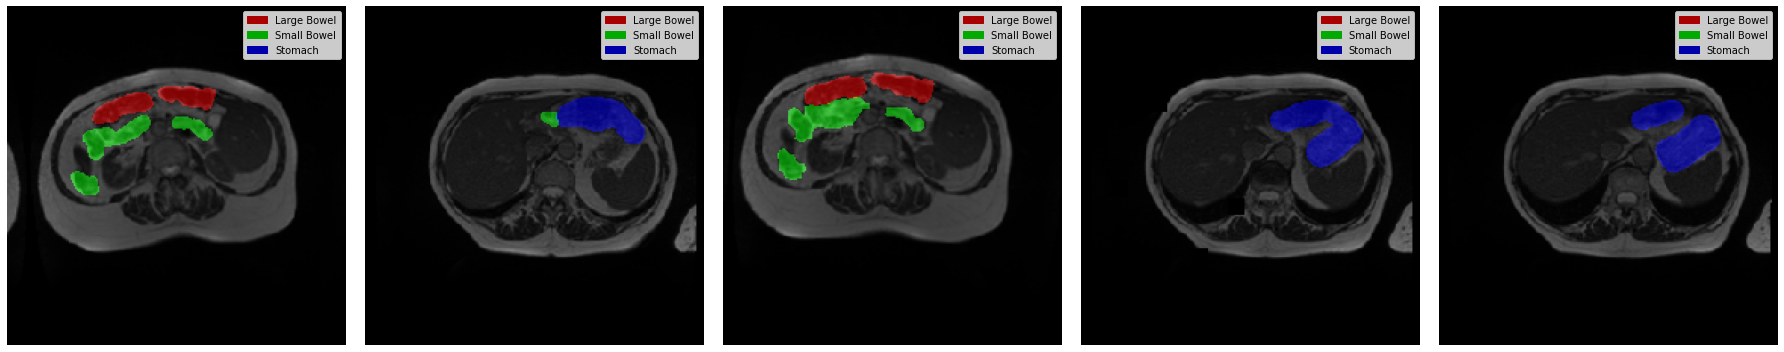

In [ ]:
plot_batch(imgs, msks, size=5)



---



# Model Training, Fine-Tuning and Evaluating

Next, let's move on to the main part of our project: Model Training, Fine-Tuning and Testing. 

> Given an input image of `height (H) x width (W) x channel (C)`, the goal of the image segmentation task is to predict the
corresponding pixel-wise label of H x W. 
<br><br>
> Generally, models in my project are trained using K-fold cross-validation to accurately measure their generalization capability. To handle the generation of augmented training MRI images and corresponding ground truths, `albumentations` library is used to augment the input images and generate corresponding ground truth labels quickly and flexiblely. <br><br>
> During training, `Dice` Loss and `Iou` Loss are employed to address the issue of data imbalance, where the background's pixels overwhelm the target classes. The training phase employs the '`Adam`' and '`AdamW`' optimization algorithms with an initial learning rate of `2e-3` and a decay rate of `1e-6.` The model is trained with a batch size of `128` samples and `30` epochs with `3` warming up epochs, and the early stopping training strategy is used to prevent overfitting. <br><br>
> In the post-processing phase and during testing, the proposed model produces qualitative figures that illustrate the final segmentation results and overlay the ground truth onto the input MRI image.

# Model1 - UNet

Historically, CNNs have emerged as the standard network model for medical image segmentation, and among them, the U-Net architecture has gained widespread popularity with its symmetrical encoder-decoder network together with skip connections that enable effective feature extraction and segmentation of medical images.



In [ ]:
#@title Configuration
import gc
gc.collect()

'''
############################
Unet Model Preparation
############################
'''
import segmentation_models_pytorch as smp

opt1 = Options()
opt1.model_name = 'Unet'
opt1.train_bs = 128     # 64
opt1.scheduler = 'CosineAnnealingLR'
opt1.warmup_epochs = 3
opt1.epochs = 30
opt1.n_fold = 5
opt1.train_criterion = 'BceTversky'

############ Model #############
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet = smp.Unet(encoder_name=opt1.backbone, 
                 encoder_weights='imagenet', 
                 in_channels=3, 
                 classes=opt1.num_classes, 
                 activation=None)

model_unet.to(device)

optimizer = optim.AdamW(model_unet.parameters(), lr=opt1.lr, weight_decay=opt1.wd)
scheduler = fetch_scheduler(opt1, optimizer)


In [ ]:
#@title Training
'''
############################
Unet Training 
############################
'''
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='model-UNet', 
                     config={k:v for k, v in dict(vars(opt1)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{opt1.img_size[0]}x{opt1.img_size[1]}|model-{opt1.model_name}",
                     group=opt1.comment,
                    )
    train_loader, valid_loader, t_len, v_len = MyLoaders(df=df_folds, fold=fold, opt_=opt1, debug=opt1.debug)
    # model     = build_model()
    
    optimizer = optim.Adam(model_unet.parameters(), lr=opt1.lr, weight_decay=opt1.wd)
    scheduler = fetch_scheduler(opt1, optimizer)
    model_unet, history = run_training(model_unet, optimizer, scheduler, opt1)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: NVIDIA A100-SXM4-40GB

Epoch 1/30

Train :   0%|          | 0/248 [00:00<?, ?it/s]

>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:19<00:00,  1.42it/s, gpu_memory=12.10 GB, lr=0.00066, valid_loss=0.2740]


Valid Dice: 0.7042 | Valid Iou(Jaccard): 0.6682
Dir made!
Valid Score Improved (-inf ---> 0.7042)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 2/30

Train :   0%|          | 0/248 [00:00<?, ?it/s]

>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:20<00:00,  1.35it/s, gpu_memory=10.47 GB, lr=0.00133, valid_loss=0.2189]


Valid Dice: 0.7427 | Valid Iou(Jaccard): 0.7069
Valid Score Improved (0.7042 ---> 0.7427)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 3/30

Train :   0%|          | 0/248 [00:00<?, ?it/s]

>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, gpu_memory=10.48 GB, lr=0.00023, valid_loss=0.1499]


Valid Dice: 0.8662 | Valid Iou(Jaccard): 0.8333
Valid Score Improved (0.7427 ---> 0.8662)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 4/30

Valid : 100%|██████████| 27/27 [00:17<00:00,  1.54it/s, gpu_memory=10.48 GB, lr=0.00023, valid_loss=0.1396]


Valid Dice: 0.8834 | Valid Iou(Jaccard): 0.8521
Valid Score Improved (0.8662 ---> 0.8834)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 5/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.35it/s, gpu_memory=10.48 GB, lr=0.00023, valid_loss=0.1368]


Valid Dice: 0.8819 | Valid Iou(Jaccard): 0.8502


Epoch 6/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, gpu_memory=10.48 GB, lr=0.00023, valid_loss=0.1370]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8849 | Valid Iou(Jaccard): 0.8543
Valid Score Improved (0.8834 ---> 0.8849)
Model Saved


Epoch 7/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, gpu_memory=10.48 GB, lr=0.00022, valid_loss=0.1357]


Valid Dice: 0.8827 | Valid Iou(Jaccard): 0.8513


Epoch 8/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.57it/s, gpu_memory=10.48 GB, lr=0.00022, valid_loss=0.1371]


Valid Dice: 0.8863 | Valid Iou(Jaccard): 0.8558
Valid Score Improved (0.8849 ---> 0.8863)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 9/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.34it/s, gpu_memory=10.48 GB, lr=0.00021, valid_loss=0.1341]


Valid Dice: 0.8862 | Valid Iou(Jaccard): 0.8557


Epoch 10/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, gpu_memory=10.48 GB, lr=0.00020, valid_loss=0.1332]


Valid Dice: 0.8895 | Valid Iou(Jaccard): 0.8592
Valid Score Improved (0.8863 ---> 0.8895)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 11/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, gpu_memory=10.49 GB, lr=0.00019, valid_loss=0.1338]


Valid Dice: 0.8870 | Valid Iou(Jaccard): 0.8565


Epoch 12/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.47it/s, gpu_memory=10.48 GB, lr=0.00018, valid_loss=0.1323]


Valid Dice: 0.8883 | Valid Iou(Jaccard): 0.8583


Epoch 13/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.54it/s, gpu_memory=10.48 GB, lr=0.00017, valid_loss=0.1336]


Valid Dice: 0.8847 | Valid Iou(Jaccard): 0.8538


Epoch 14/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.61it/s, gpu_memory=10.48 GB, lr=0.00016, valid_loss=0.1373]


Valid Dice: 0.8828 | Valid Iou(Jaccard): 0.8516


Epoch 15/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.55it/s, gpu_memory=10.49 GB, lr=0.00015, valid_loss=0.1374]


Valid Dice: 0.8851 | Valid Iou(Jaccard): 0.8541


Epoch 16/30

Valid : 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, gpu_memory=10.48 GB, lr=0.00013, valid_loss=0.1336]


Valid Dice: 0.8864 | Valid Iou(Jaccard): 0.8555


Epoch 17/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.56it/s, gpu_memory=10.49 GB, lr=0.00012, valid_loss=0.1337]


Valid Dice: 0.8878 | Valid Iou(Jaccard): 0.8574


Epoch 18/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.56it/s, gpu_memory=10.49 GB, lr=0.00011, valid_loss=0.1325]


Valid Dice: 0.8876 | Valid Iou(Jaccard): 0.8568


Epoch 19/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.57it/s, gpu_memory=10.49 GB, lr=0.00010, valid_loss=0.1340]


Valid Dice: 0.8820 | Valid Iou(Jaccard): 0.8513


Epoch 20/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.54it/s, gpu_memory=10.48 GB, lr=0.00008, valid_loss=0.1355]


Valid Dice: 0.8868 | Valid Iou(Jaccard): 0.8564


Epoch 21/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.67it/s, gpu_memory=10.49 GB, lr=0.00007, valid_loss=0.1341]


Valid Dice: 0.8873 | Valid Iou(Jaccard): 0.8568


Epoch 22/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.56it/s, gpu_memory=10.48 GB, lr=0.00006, valid_loss=0.1338]


Valid Dice: 0.8870 | Valid Iou(Jaccard): 0.8564


Epoch 23/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.60it/s, gpu_memory=10.48 GB, lr=0.00005, valid_loss=0.1345]


Valid Dice: 0.8872 | Valid Iou(Jaccard): 0.8567


Epoch 24/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.60it/s, gpu_memory=10.48 GB, lr=0.00004, valid_loss=0.1357]


Valid Dice: 0.8861 | Valid Iou(Jaccard): 0.8561


Epoch 25/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.59it/s, gpu_memory=10.48 GB, lr=0.00003, valid_loss=0.1348]


Valid Dice: 0.8849 | Valid Iou(Jaccard): 0.8548


Epoch 26/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.68it/s, gpu_memory=10.48 GB, lr=0.00002, valid_loss=0.1356]


Valid Dice: 0.8852 | Valid Iou(Jaccard): 0.8550


Epoch 27/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.62it/s, gpu_memory=10.48 GB, lr=0.00002, valid_loss=0.1356]


Valid Dice: 0.8842 | Valid Iou(Jaccard): 0.8538


Epoch 28/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.55it/s, gpu_memory=10.48 GB, lr=0.00001, valid_loss=0.1347]


Valid Dice: 0.8854 | Valid Iou(Jaccard): 0.8552


Epoch 29/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.68it/s, gpu_memory=10.49 GB, lr=0.00001, valid_loss=0.1346]


Valid Dice: 0.8855 | Valid Iou(Jaccard): 0.8553


Epoch 30/30

Valid : 100%|██████████| 27/27 [00:10<00:00,  2.50it/s, gpu_memory=10.48 GB, lr=0.00000, valid_loss=0.1352]


Valid Dice: 0.8856 | Valid Iou(Jaccard): 0.8553


Training complete in 1h 40m 6s
Best Score: 0.8592


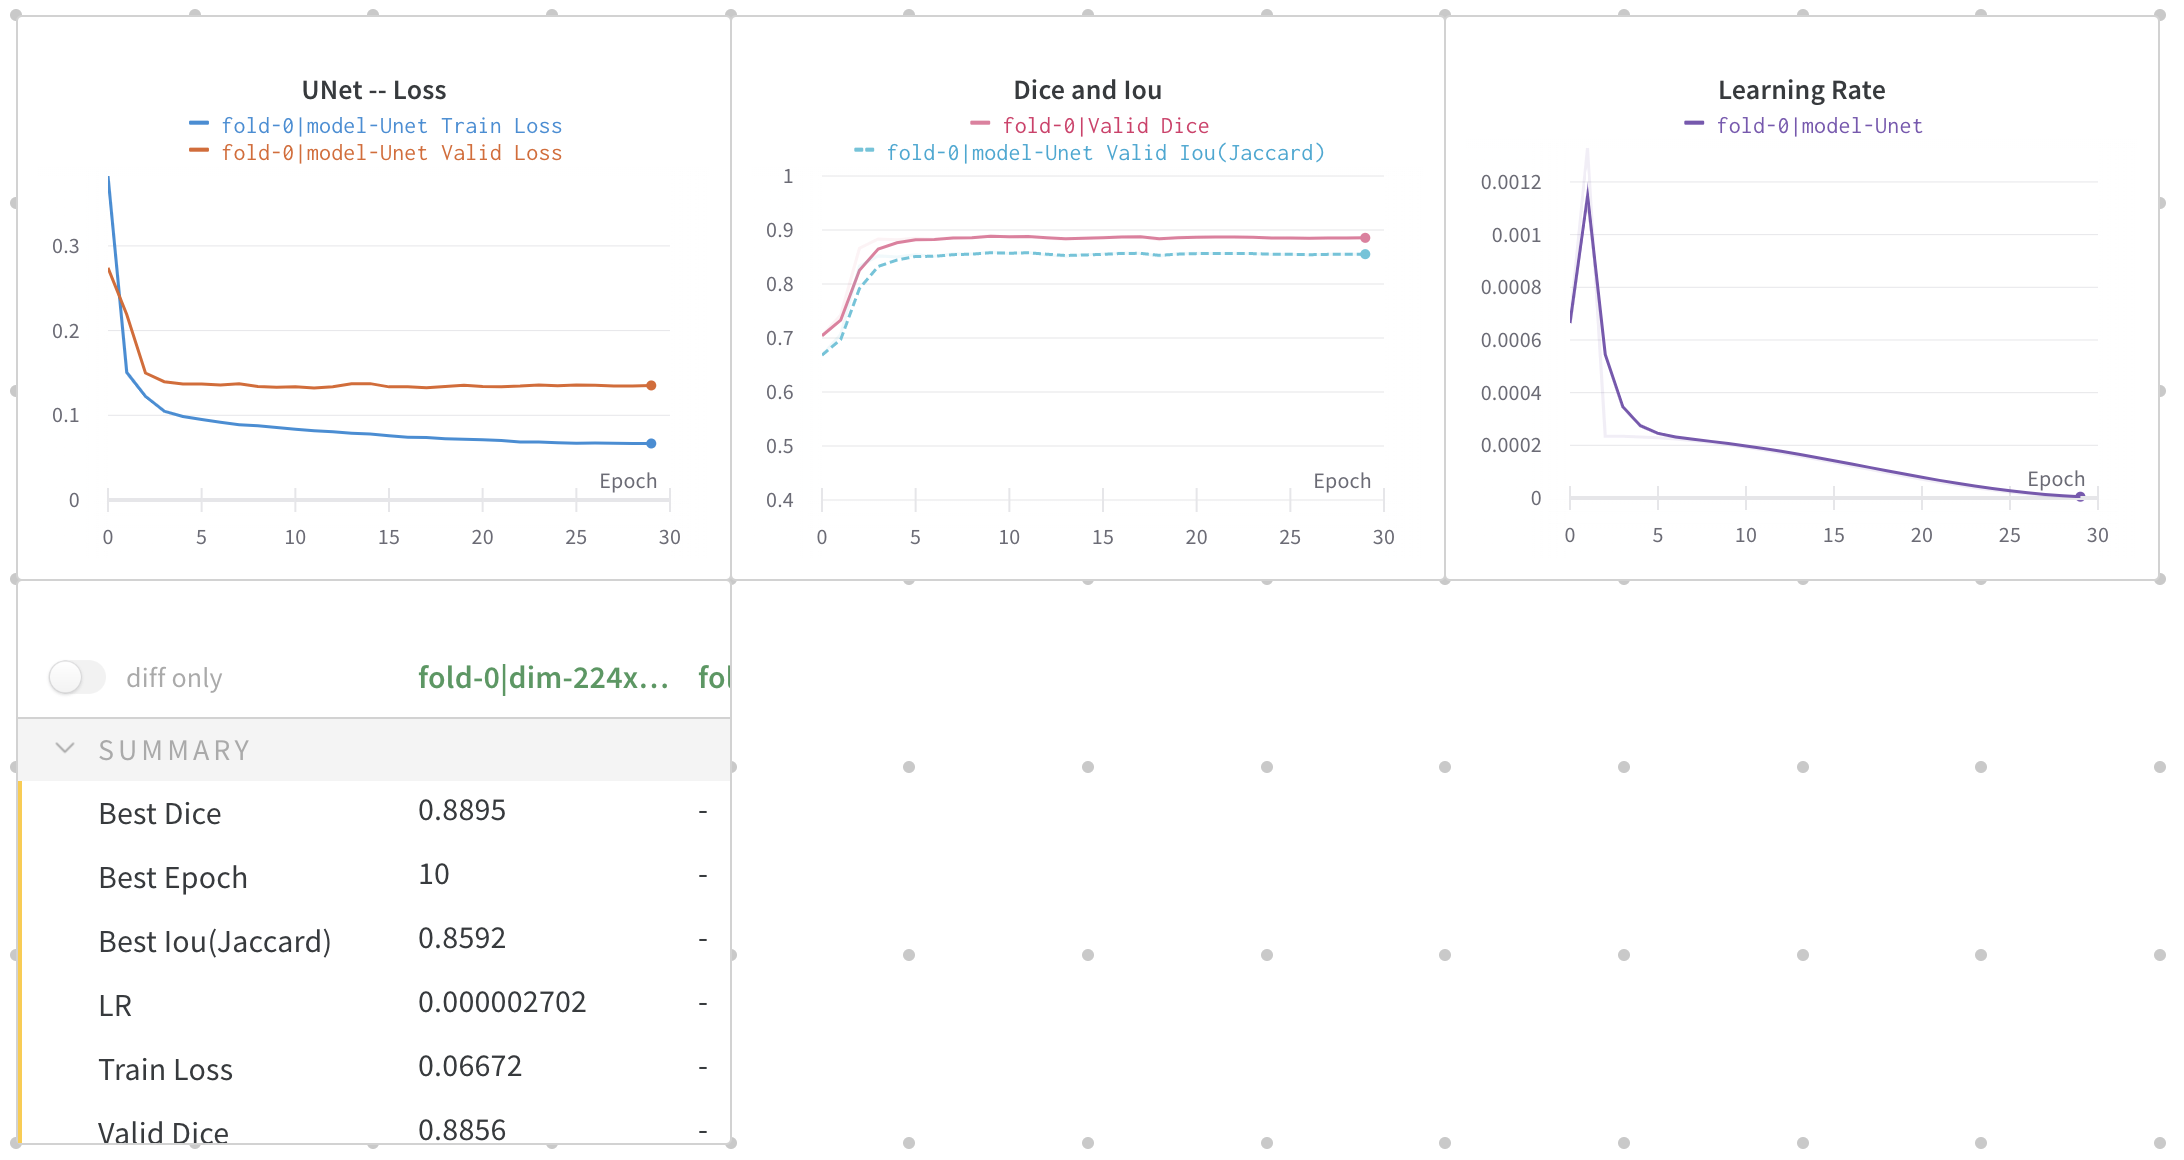

The above image shows a dashboard of the Unet model's measure metrics, including the variation within Loss, Dice & IoU score, and Learning Rate over time. We can see that although the Dice and IoU scores have similar trends on both the training and testing sets, the Loss, however is converging more slowly on the testing set, which is relatively obvious. This suggesting that the model has a over-fitting probability.

>UNet ----<br>
Best Dice: 0.8895<br>
Best Iou: 0.8592<br>
Best Train Loss: 0.06672<br>
Best Valid Loss: 0.13524 <br>

In [ ]:
#@title Testing & Prediction
'''
############################
Unet Testing 
############################
'''
test_dataset = MyDataset(df_folds[(df_folds['fold'] == 0) & (df_folds['empty'] == 0)].sample(frac=1.0), label=False, 
                            trans=val_trans(opt1))
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(opt1.device, dtype=torch.float)

preds = []
for fold in range(1):
    model_unet_test = smp.Unet(encoder_name=opt1.backbone, 
                 encoder_weights='imagenet', 
                 in_channels=3, 
                 classes=opt1.num_classes, 
                 activation=None)
    
    model_unet_test.to(device)
    model_unet_test.load_state_dict(torch.load(MODEL_PATH+'/'+opt1.model_name+f"/best_epoch-{fold:02d}.pth"))
    model_unet_test.eval()
    
    with torch.no_grad():
        pred = model_unet_test(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

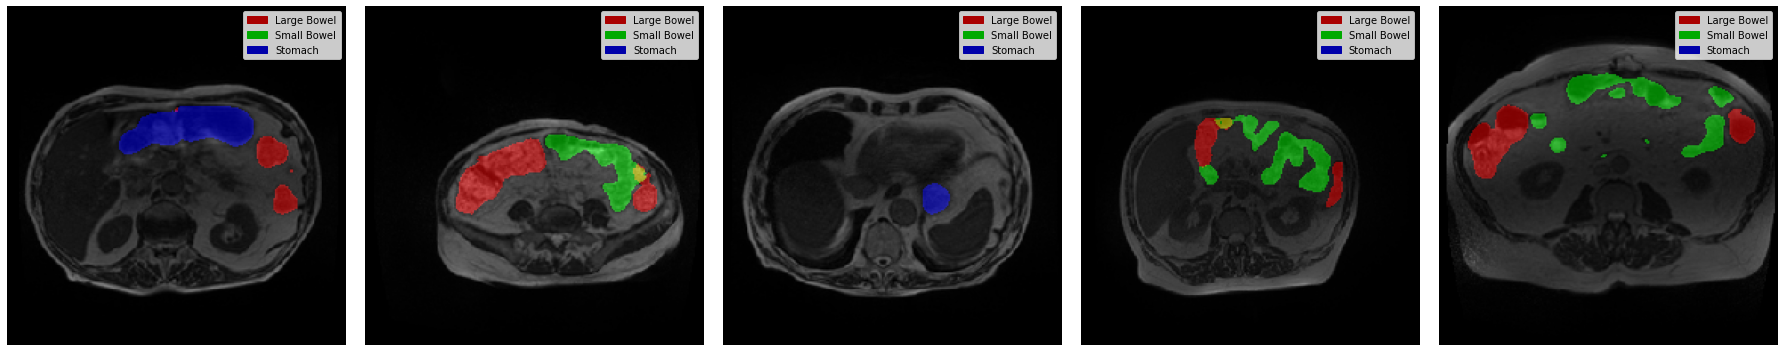

In [ ]:
# Predicting results
plot_batch(imgs, preds, size=5)

In [ ]:
#@title Model summary
# Unet Model summary
summary(model_unet, input_size = (3, 224, 224), batch_size = opt1.train_bs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1         [128, 3, 225, 225]               0
Conv2dStaticSamePadding-2        [128, 32, 112, 112]             864
       BatchNorm2d-3        [128, 32, 112, 112]              64
MemoryEfficientSwish-4        [128, 32, 112, 112]               0
         ZeroPad2d-5        [128, 32, 114, 114]               0
Conv2dStaticSamePadding-6        [128, 32, 112, 112]             288
       BatchNorm2d-7        [128, 32, 112, 112]              64
MemoryEfficientSwish-8        [128, 32, 112, 112]               0
          Identity-9            [128, 32, 1, 1]               0
Conv2dStaticSamePadding-10             [128, 8, 1, 1]             264
MemoryEfficientSwish-11             [128, 8, 1, 1]               0
         Identity-12             [128, 8, 1, 1]               0
Conv2dStaticSamePadding-13            [128, 32, 1, 1]             288
         I

### Tuning Model: Replace ReLU by Mish 
The activation function is a critical component of neural networks, allowing for the introduction of nonlinearity in the model. It plays a crucial role in both the training and evaluation of deep neural networks. There are several commonly used activation functions, such as ReLU, Sigmoid, Leaky ReLU, and Tanh, as well as the more recently introduced Swish. However, Mish is a state-of-the-art activation function that outperforms both ReLU and Swish on complex datasets. Additionally, the simplicity of the Mish function makes it easy to implement in neural networks. So in this stage, we decided to replace ReLU activation layer with Mish.

In [ ]:

'''
Tuning by Mish activation layer
'''
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# Define Mish activation function
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Define UNet model with ReLU activation
model1_tuned = smp.Unet(
    encoder_name=opt1.backbone,
    encoder_weights="imagenet",
    in_channels=3,
    classes=opt1.num_classes,
)

# Replace activation function in encoder blocks with Mish
for name, module in model1_tuned.encoder.named_children():
    if isinstance(module, nn.Sequential):
        for n, m in module.named_children():
            if isinstance(m, nn.ReLU):
                module[int(n)] = Mish()

# Replace activation function in decoder blocks with Mish
for name, module in model1_tuned.decoder.named_children():
    if isinstance(module, nn.Sequential):
        for n, m in module.named_children():
            if isinstance(m, nn.ReLU):
                module[int(n)] = Mish()

# Use modified UNet model as usual

import gc
gc.collect()

'''
############################
Unet-tuned Model Preparation
############################
'''
opt1_ = Options()
opt1_.model_name = 'Unet_tuned'
opt1_.train_bs = 128     # 64
opt1_.scheduler = 'CosineAnnealingLR'
opt1_.warmup_epochs = 3
opt1_.epochs = 30
opt1_.n_fold = 5
opt1_.train_criterion = 'BceTversky'

############ Model #############
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1_tuned.to(device)

optimizer = optim.AdamW(model1_tuned.parameters(), lr=opt1_.lr, weight_decay=opt1_.wd)
scheduler = fetch_scheduler(opt1_, optimizer)


In [ ]:

'''
############################
Tuned Unet Training 
############################
'''
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='model-UNet', 
                     config={k:v for k, v in dict(vars(opt1_)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{opt1_.img_size[0]}x{opt1_.img_size[1]}|model-{opt1_.model_name}",
                     group=opt1_.comment,
                    )
    train_loader, valid_loader, t_len, v_len = MyLoaders(df=df_folds, fold=fold, opt_=opt1_, debug=opt1_.debug)
    # model     = build_model()
    
    optimizer = optim.AdamW(model1_tuned.parameters(), lr=opt1_.lr, weight_decay=opt1_.wd)
    scheduler = fetch_scheduler(opt1_, optimizer)
    model1_tuned, history = run_training(model1_tuned, optimizer, scheduler, opt1_)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, 
                       height=720))

###############
### Fold: 0
###############


cuda: NVIDIA A100-SXM4-40GB

Epoch 1/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:17<00:00,  1.54it/s, gpu_memory=14.84 GB, lr=0.00066, valid_loss=0.2964]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.6686 | Valid Iou(Jaccard): 0.6333
Dir made!
Valid Score Improved (-inf ---> 0.6686)
Model Saved


Epoch 2/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:11<00:00,  2.36it/s, gpu_memory=14.86 GB, lr=0.00133, valid_loss=0.2232]


Valid Dice: 0.6516 | Valid Iou(Jaccard): 0.6140


Epoch 3/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:11<00:00,  2.29it/s, gpu_memory=14.88 GB, lr=0.00023, valid_loss=0.1709]


Valid Dice: 0.8178 | Valid Iou(Jaccard): 0.7841
Valid Score Improved (0.6686 ---> 0.8178)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 4/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.39it/s, gpu_memory=14.86 GB, lr=0.00023, valid_loss=0.1415]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8821 | Valid Iou(Jaccard): 0.8510
Valid Score Improved (0.8178 ---> 0.8821)
Model Saved


Epoch 5/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.38it/s, gpu_memory=14.87 GB, lr=0.00023, valid_loss=0.1368]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8857 | Valid Iou(Jaccard): 0.8546
Valid Score Improved (0.8821 ---> 0.8857)
Model Saved


Epoch 6/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.28it/s, gpu_memory=14.87 GB, lr=0.00023, valid_loss=0.1406]


Valid Dice: 0.8821 | Valid Iou(Jaccard): 0.8501


Epoch 7/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.29it/s, gpu_memory=14.87 GB, lr=0.00022, valid_loss=0.1361]


Valid Dice: 0.8849 | Valid Iou(Jaccard): 0.8539


Epoch 8/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.25it/s, gpu_memory=14.87 GB, lr=0.00022, valid_loss=0.1378]


Valid Dice: 0.8852 | Valid Iou(Jaccard): 0.8533


Epoch 9/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.23it/s, gpu_memory=14.87 GB, lr=0.00021, valid_loss=0.1365]


Valid Dice: 0.8860 | Valid Iou(Jaccard): 0.8545
Valid Score Improved (0.8857 ---> 0.8860)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 10/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.28it/s, gpu_memory=14.87 GB, lr=0.00020, valid_loss=0.1387]


Valid Dice: 0.8802 | Valid Iou(Jaccard): 0.8487


Epoch 11/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, gpu_memory=14.88 GB, lr=0.00019, valid_loss=0.1330]


Valid Dice: 0.8801 | Valid Iou(Jaccard): 0.8488


Epoch 12/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.28it/s, gpu_memory=14.87 GB, lr=0.00018, valid_loss=0.1371]


Valid Dice: 0.8847 | Valid Iou(Jaccard): 0.8535


Epoch 13/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, gpu_memory=14.87 GB, lr=0.00017, valid_loss=0.1329]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8881 | Valid Iou(Jaccard): 0.8572
Valid Score Improved (0.8860 ---> 0.8881)
Model Saved


Epoch 14/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.38it/s, gpu_memory=14.87 GB, lr=0.00016, valid_loss=0.1346]


Valid Dice: 0.8859 | Valid Iou(Jaccard): 0.8554


Epoch 15/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.22it/s, gpu_memory=14.87 GB, lr=0.00015, valid_loss=0.1342]


Valid Dice: 0.8843 | Valid Iou(Jaccard): 0.8530


Epoch 16/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.35it/s, gpu_memory=14.88 GB, lr=0.00013, valid_loss=0.1346]


Valid Dice: 0.8860 | Valid Iou(Jaccard): 0.8549


Epoch 17/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, gpu_memory=14.87 GB, lr=0.00012, valid_loss=0.1330]


Valid Dice: 0.8855 | Valid Iou(Jaccard): 0.8544


Epoch 18/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, gpu_memory=14.87 GB, lr=0.00011, valid_loss=0.1324]


Valid Dice: 0.8851 | Valid Iou(Jaccard): 0.8542


Epoch 19/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, gpu_memory=14.87 GB, lr=0.00010, valid_loss=0.1309]


Valid Dice: 0.8879 | Valid Iou(Jaccard): 0.8571


Epoch 20/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, gpu_memory=14.87 GB, lr=0.00008, valid_loss=0.1341]


Valid Dice: 0.8867 | Valid Iou(Jaccard): 0.8560


Epoch 21/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.29it/s, gpu_memory=14.87 GB, lr=0.00007, valid_loss=0.1344]


Valid Dice: 0.8865 | Valid Iou(Jaccard): 0.8554


Epoch 22/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, gpu_memory=14.87 GB, lr=0.00006, valid_loss=0.1329]


Valid Dice: 0.8870 | Valid Iou(Jaccard): 0.8558


Epoch 23/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.23it/s, gpu_memory=14.88 GB, lr=0.00005, valid_loss=0.1331]


Valid Dice: 0.8872 | Valid Iou(Jaccard): 0.8565


Epoch 24/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.12it/s, gpu_memory=14.88 GB, lr=0.00004, valid_loss=0.1346]


Valid Dice: 0.8854 | Valid Iou(Jaccard): 0.8545


Epoch 25/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.21it/s, gpu_memory=14.87 GB, lr=0.00003, valid_loss=0.1339]


Valid Dice: 0.8868 | Valid Iou(Jaccard): 0.8561


Epoch 26/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, gpu_memory=14.88 GB, lr=0.00002, valid_loss=0.1321]


Valid Dice: 0.8883 | Valid Iou(Jaccard): 0.8574
Valid Score Improved (0.8881 ---> 0.8883)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 27/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.27it/s, gpu_memory=14.87 GB, lr=0.00002, valid_loss=0.1328]


Valid Dice: 0.8887 | Valid Iou(Jaccard): 0.8579
Valid Score Improved (0.8883 ---> 0.8887)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 28/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.28it/s, gpu_memory=14.87 GB, lr=0.00001, valid_loss=0.1334]


Valid Dice: 0.8869 | Valid Iou(Jaccard): 0.8560


Epoch 29/30



Valid : 100%|██████████| 27/27 [00:11<00:00,  2.27it/s, gpu_memory=14.87 GB, lr=0.00001, valid_loss=0.1329]


Valid Dice: 0.8875 | Valid Iou(Jaccard): 0.8567


Epoch 30/30



Valid : 100%|██████████| 27/27 [00:12<00:00,  2.18it/s, gpu_memory=14.88 GB, lr=0.00000, valid_loss=0.1326]


Valid Dice: 0.8878 | Valid Iou(Jaccard): 0.8570


Training complete in 1h 37m 7s
Best Score: 0.8579


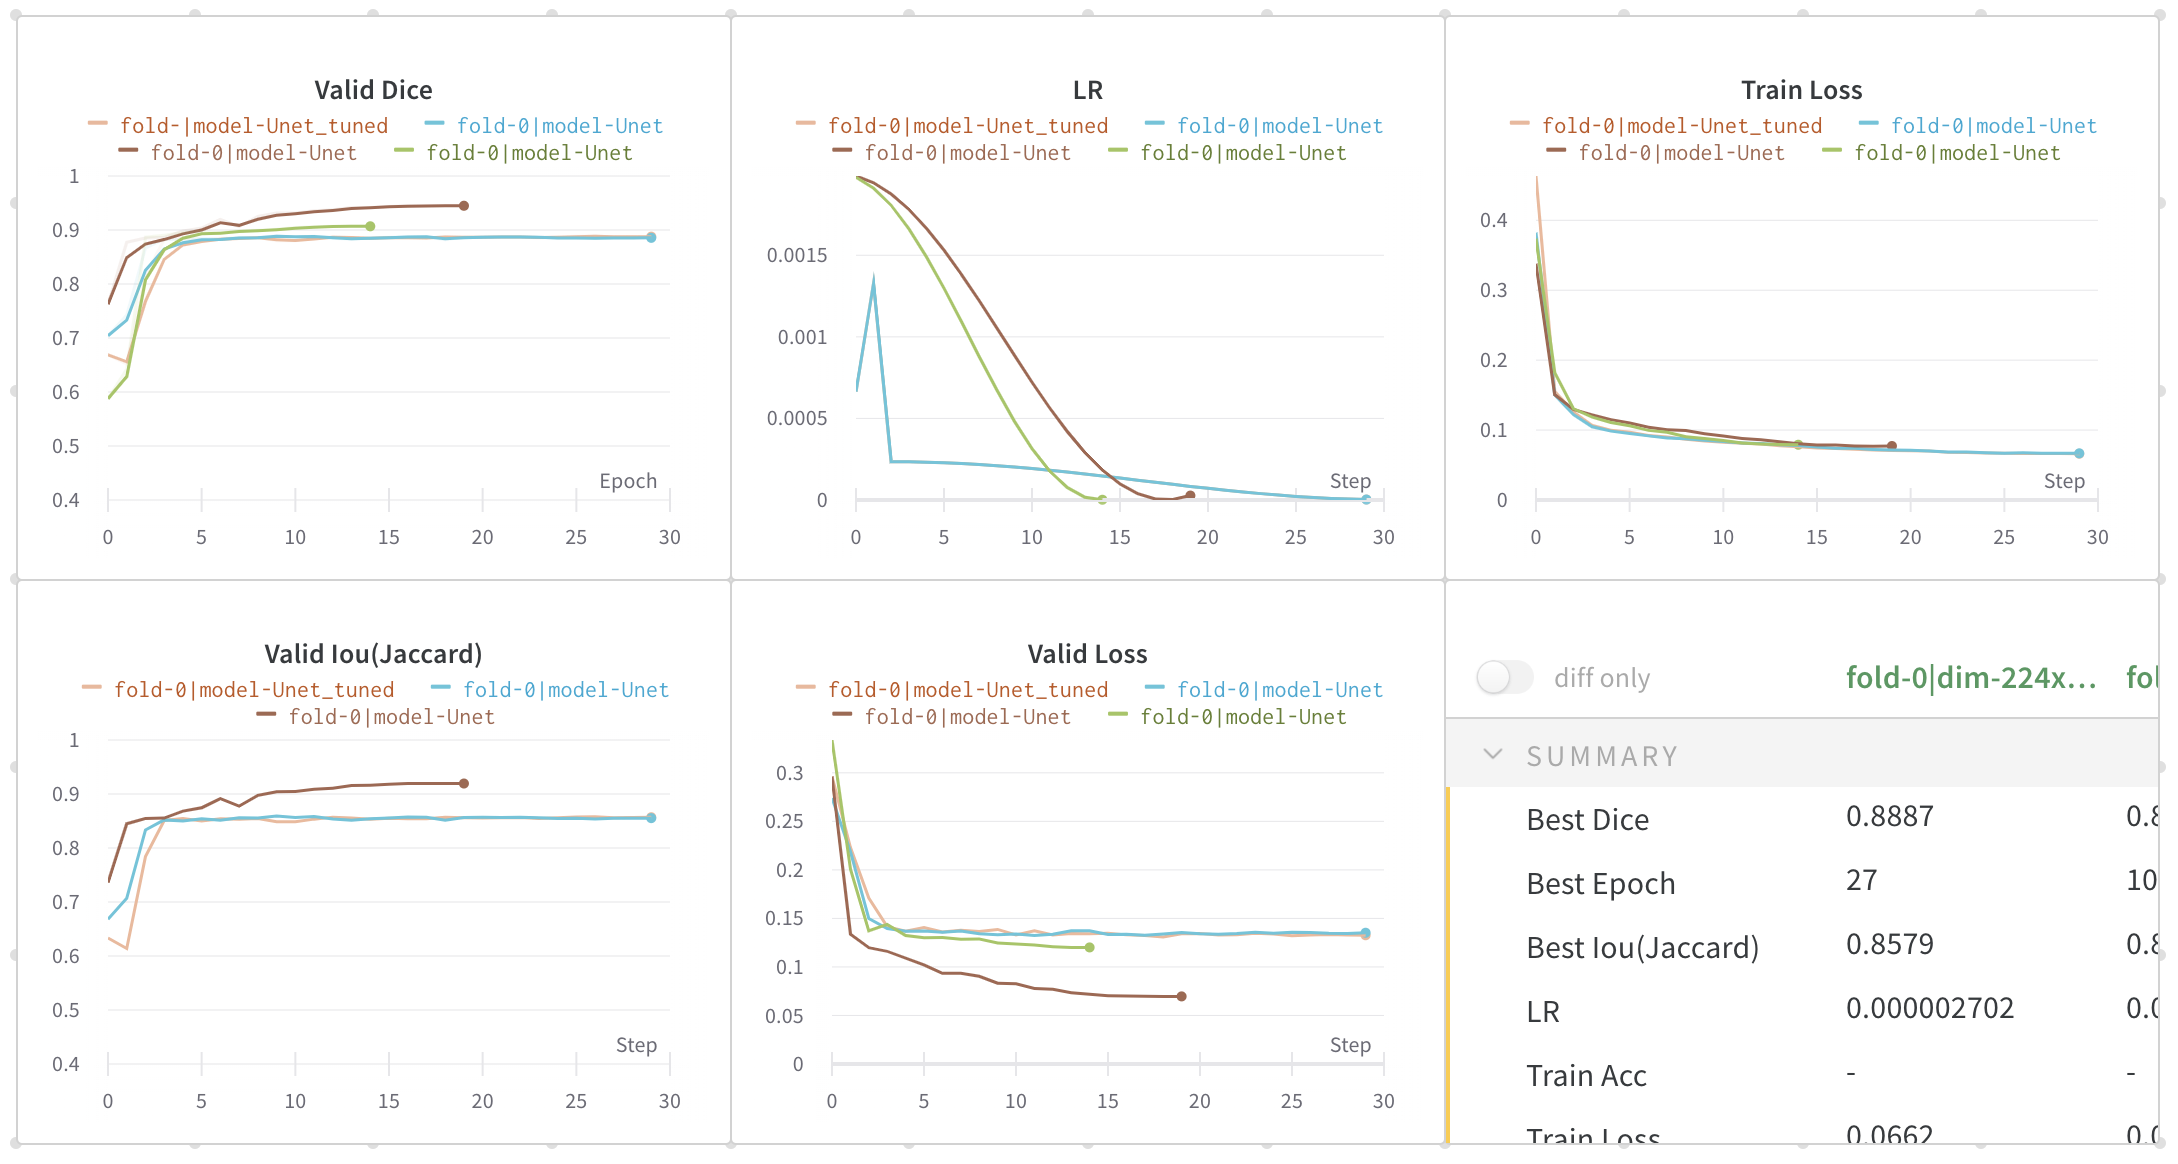

Based on the results shown in the graph, we can observe that replacing Mish with the UNet activation function did not have a significant impact on the Dice and IoU scores. Several factors could lead to this: <br>
Firstly, the design architecture of the UNet model is already effective in extracting features and restoring low-level details of the image. <br>
Secondly, we are currently using a pre-trained model, and Mish's performance may be more significant if we train the model from scratch. <br>
Additionally, factors such as batch size and epoch numbers could also affect the results, but unfortunately, we cannot upgrade to a better GPU with more memory due to practical limitations.

Therefore, our next step is to focus on replacing the model infrastructure to improve the performance.

# Model2 - LeVit UNet

The LeViT model is a vision transformer architecture that uses self-attention and transformer blocks to process images, while the U-Net model is a popular architecture for image segmentation tasks.

By combining these two models, LeViT UNet aims to achieve better segmentation results while using fewer parameters than traditional U-Net models. It does this by using the attention mechanism of the LeViT model to focus on relevant image features for the segmentation task, reducing the amount of unnecessary computation.

In [ ]:
!git clone https://github.com/facebookresearch/LeViT.git
!pip install ptflops

In [ ]:
#@title Configuration
import gc
gc.collect()

'''
############################
LeVit Unet Model Preparation
############################
'''
import sys
sys.path.append('/content/LeViT/')
from LeViT_UNet_384 import Build_LeViT_UNet_384

opt2 = Options()
opt2.model_name = 'LeVitrUnet'
opt2.train_bs = 128     # 64
opt2.scheduler = 'CosineAnnealingLR'
opt2.warmup_epochs = 3
opt2.epochs = 30
opt2.n_fold = 5

############ Model #############
model2 = Build_LeViT_UNet_384(pretrained=True, num_classes=opt2.num_classes)        # model output channels (number of classes in your dataset)
                                    
model2.to(opt2.device)

optimizer = optim.AdamW(model2.parameters(), lr=opt2.lr, weight_decay=opt2.wd)
scheduler = fetch_scheduler(opt2, optimizer)


0
1
2
1:  block_1.0.m.attention_biases
1:  block_1.0.m.attention_bias_idxs
1:  block_1.0.m.qkv.c.weight
1:  block_1.0.m.qkv.bn.weight
1:  block_1.0.m.qkv.bn.bias
1:  block_1.0.m.qkv.bn.running_mean
1:  block_1.0.m.qkv.bn.running_var
1:  block_1.0.m.qkv.bn.num_batches_tracked
1:  block_1.0.m.proj.1.c.weight
1:  block_1.0.m.proj.1.bn.weight
1:  block_1.0.m.proj.1.bn.bias
1:  block_1.0.m.proj.1.bn.running_mean
1:  block_1.0.m.proj.1.bn.running_var
1:  block_1.0.m.proj.1.bn.num_batches_tracked
1:  block_1.1.m.0.c.weight
1:  block_1.1.m.0.bn.weight
1:  block_1.1.m.0.bn.bias
1:  block_1.1.m.0.bn.running_mean
1:  block_1.1.m.0.bn.running_var
1:  block_1.1.m.0.bn.num_batches_tracked
1:  block_1.1.m.2.c.weight
1:  block_1.1.m.2.bn.weight
1:  block_1.1.m.2.bn.bias
1:  block_1.1.m.2.bn.running_mean
1:  block_1.1.m.2.bn.running_var
1:  block_1.1.m.2.bn.num_batches_tracked
1:  block_1.2.m.attention_biases
1:  block_1.2.m.attention_bias_idxs
1:  block_1.2.m.qkv.c.weight
1:  block_1.2.m.qkv.bn.weight

In [ ]:
#@title Training
'''
############################
LeVit Unet Training 
############################
'''
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='model-LeViT', 
                     config={k:v for k, v in dict(vars(opt2)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{opt2.img_size[0]}x{opt2.img_size[1]}|model-{opt2.model_name}",
                     group=opt2.comment,
                    )
    train_loader, valid_loader, t_len, v_len = MyLoaders(df=df_folds, fold=fold, opt_=opt2, debug=opt2.debug, rgb=False)
    optimizer = optim.Adam(model2.parameters(), lr=opt2.lr, weight_decay=opt2.wd)
    scheduler = fetch_scheduler(opt2, optimizer)
    model2, history = run_training(model2, optimizer, scheduler, opt2)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: NVIDIA A100-SXM4-40GB

Epoch 1/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:35<00:00,  1.31s/it, gpu_memory=19.04 GB, lr=0.00066, valid_loss=0.3365]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.7216 | Valid Iou(Jaccard): 0.6874
Valid Score Improved (-inf ---> 0.7216)
Model Saved


Epoch 2/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, gpu_memory=27.73 GB, lr=0.00133, valid_loss=0.3143]


Valid Dice: 0.6892 | Valid Iou(Jaccard): 0.6523


Epoch 3/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:27<00:00,  1.01s/it, gpu_memory=27.69 GB, lr=0.00023, valid_loss=0.2735]


Valid Dice: 0.7570 | Valid Iou(Jaccard): 0.7209
Valid Score Improved (0.7216 ---> 0.7570)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 4/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.00s/it, gpu_memory=27.68 GB, lr=0.00023, valid_loss=0.2541]


Valid Dice: 0.7698 | Valid Iou(Jaccard): 0.7323
Valid Score Improved (0.7570 ---> 0.7698)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 5/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.01s/it, gpu_memory=27.67 GB, lr=0.00023, valid_loss=0.2509]


Valid Dice: 0.7805 | Valid Iou(Jaccard): 0.7428
Valid Score Improved (0.7698 ---> 0.7805)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 6/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, gpu_memory=27.64 GB, lr=0.00023, valid_loss=0.2368]


Valid Dice: 0.7880 | Valid Iou(Jaccard): 0.7507
Valid Score Improved (0.7805 ---> 0.7880)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 7/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.01s/it, gpu_memory=27.65 GB, lr=0.00022, valid_loss=0.2505]


Valid Dice: 0.7992 | Valid Iou(Jaccard): 0.7635
Valid Score Improved (0.7880 ---> 0.7992)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 8/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.02s/it, gpu_memory=27.64 GB, lr=0.00022, valid_loss=0.2267]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8065 | Valid Iou(Jaccard): 0.7698
Valid Score Improved (0.7992 ---> 0.8065)
Model Saved


Epoch 9/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, gpu_memory=27.64 GB, lr=0.00021, valid_loss=0.2192]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8115 | Valid Iou(Jaccard): 0.7746
Valid Score Improved (0.8065 ---> 0.8115)
Model Saved


Epoch 10/30



Valid : 100%|██████████| 27/27 [00:24<00:00,  1.09it/s, gpu_memory=27.70 GB, lr=0.00020, valid_loss=0.2220]


Valid Dice: 0.8161 | Valid Iou(Jaccard): 0.7789
Valid Score Improved (0.8115 ---> 0.8161)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 11/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.04it/s, gpu_memory=27.64 GB, lr=0.00019, valid_loss=0.2179]


Valid Dice: 0.8186 | Valid Iou(Jaccard): 0.7827
Valid Score Improved (0.8161 ---> 0.8186)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 12/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, gpu_memory=27.64 GB, lr=0.00018, valid_loss=0.2221]


Valid Dice: 0.8223 | Valid Iou(Jaccard): 0.7863
Valid Score Improved (0.8186 ---> 0.8223)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 13/30



Valid : 100%|██████████| 27/27 [00:25<00:00,  1.05it/s, gpu_memory=27.64 GB, lr=0.00017, valid_loss=0.2112]


Valid Dice: 0.8245 | Valid Iou(Jaccard): 0.7880
Valid Score Improved (0.8223 ---> 0.8245)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 14/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, gpu_memory=28.05 GB, lr=0.00016, valid_loss=0.2136]


Valid Dice: 0.8239 | Valid Iou(Jaccard): 0.7877


Epoch 15/30



Valid : 100%|██████████| 27/27 [00:28<00:00,  1.05s/it, gpu_memory=27.64 GB, lr=0.00015, valid_loss=0.2132]


Valid Dice: 0.8300 | Valid Iou(Jaccard): 0.7943
Valid Score Improved (0.8245 ---> 0.8300)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 16/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, gpu_memory=28.05 GB, lr=0.00013, valid_loss=0.2144]


Valid Dice: 0.8166 | Valid Iou(Jaccard): 0.7799


Epoch 17/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, gpu_memory=27.62 GB, lr=0.00012, valid_loss=0.2085]

Valid Dice: 0.8245 | Valid Iou(Jaccard): 0.7883


Epoch 18/30




Valid : 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, gpu_memory=27.64 GB, lr=0.00011, valid_loss=0.2112]


Valid Dice: 0.8241 | Valid Iou(Jaccard): 0.7884


Epoch 19/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.03s/it, gpu_memory=27.64 GB, lr=0.00010, valid_loss=0.2085]


Valid Dice: 0.8305 | Valid Iou(Jaccard): 0.7952
Valid Score Improved (0.8300 ---> 0.8305)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 20/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.04it/s, gpu_memory=27.64 GB, lr=0.00008, valid_loss=0.2067]


Valid Dice: 0.8298 | Valid Iou(Jaccard): 0.7940


Epoch 21/30



Valid : 100%|██████████| 27/27 [00:25<00:00,  1.07it/s, gpu_memory=27.64 GB, lr=0.00007, valid_loss=0.2009]


Valid Dice: 0.8299 | Valid Iou(Jaccard): 0.7939


Epoch 22/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, gpu_memory=27.64 GB, lr=0.00006, valid_loss=0.2035]


Valid Dice: 0.8280 | Valid Iou(Jaccard): 0.7923


Epoch 23/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.00it/s, gpu_memory=27.64 GB, lr=0.00005, valid_loss=0.2063]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8311 | Valid Iou(Jaccard): 0.7960
Valid Score Improved (0.8305 ---> 0.8311)
Model Saved


Epoch 24/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.00s/it, gpu_memory=27.64 GB, lr=0.00004, valid_loss=0.2011]


Valid Dice: 0.8339 | Valid Iou(Jaccard): 0.7981
Valid Score Improved (0.8311 ---> 0.8339)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 25/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.00s/it, gpu_memory=27.64 GB, lr=0.00003, valid_loss=0.2012]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Valid Dice: 0.8339 | Valid Iou(Jaccard): 0.7985
Valid Score Improved (0.8339 ---> 0.8339)
Model Saved


Epoch 26/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.02s/it, gpu_memory=27.64 GB, lr=0.00002, valid_loss=0.2041]


Valid Dice: 0.8309 | Valid Iou(Jaccard): 0.7953


Epoch 27/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.04it/s, gpu_memory=27.69 GB, lr=0.00002, valid_loss=0.2041]


Valid Dice: 0.8313 | Valid Iou(Jaccard): 0.7956


Epoch 28/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, gpu_memory=27.69 GB, lr=0.00001, valid_loss=0.2038]


Valid Dice: 0.8298 | Valid Iou(Jaccard): 0.7940


Epoch 29/30



Valid : 100%|██████████| 27/27 [00:27<00:00,  1.01s/it, gpu_memory=27.69 GB, lr=0.00001, valid_loss=0.2038]


Valid Dice: 0.8291 | Valid Iou(Jaccard): 0.7933


Epoch 30/30



Valid : 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, gpu_memory=27.69 GB, lr=0.00000, valid_loss=0.2024]


Valid Dice: 0.8311 | Valid Iou(Jaccard): 0.7954


Training complete in 2h 15m 33s
Best Score: 0.7985


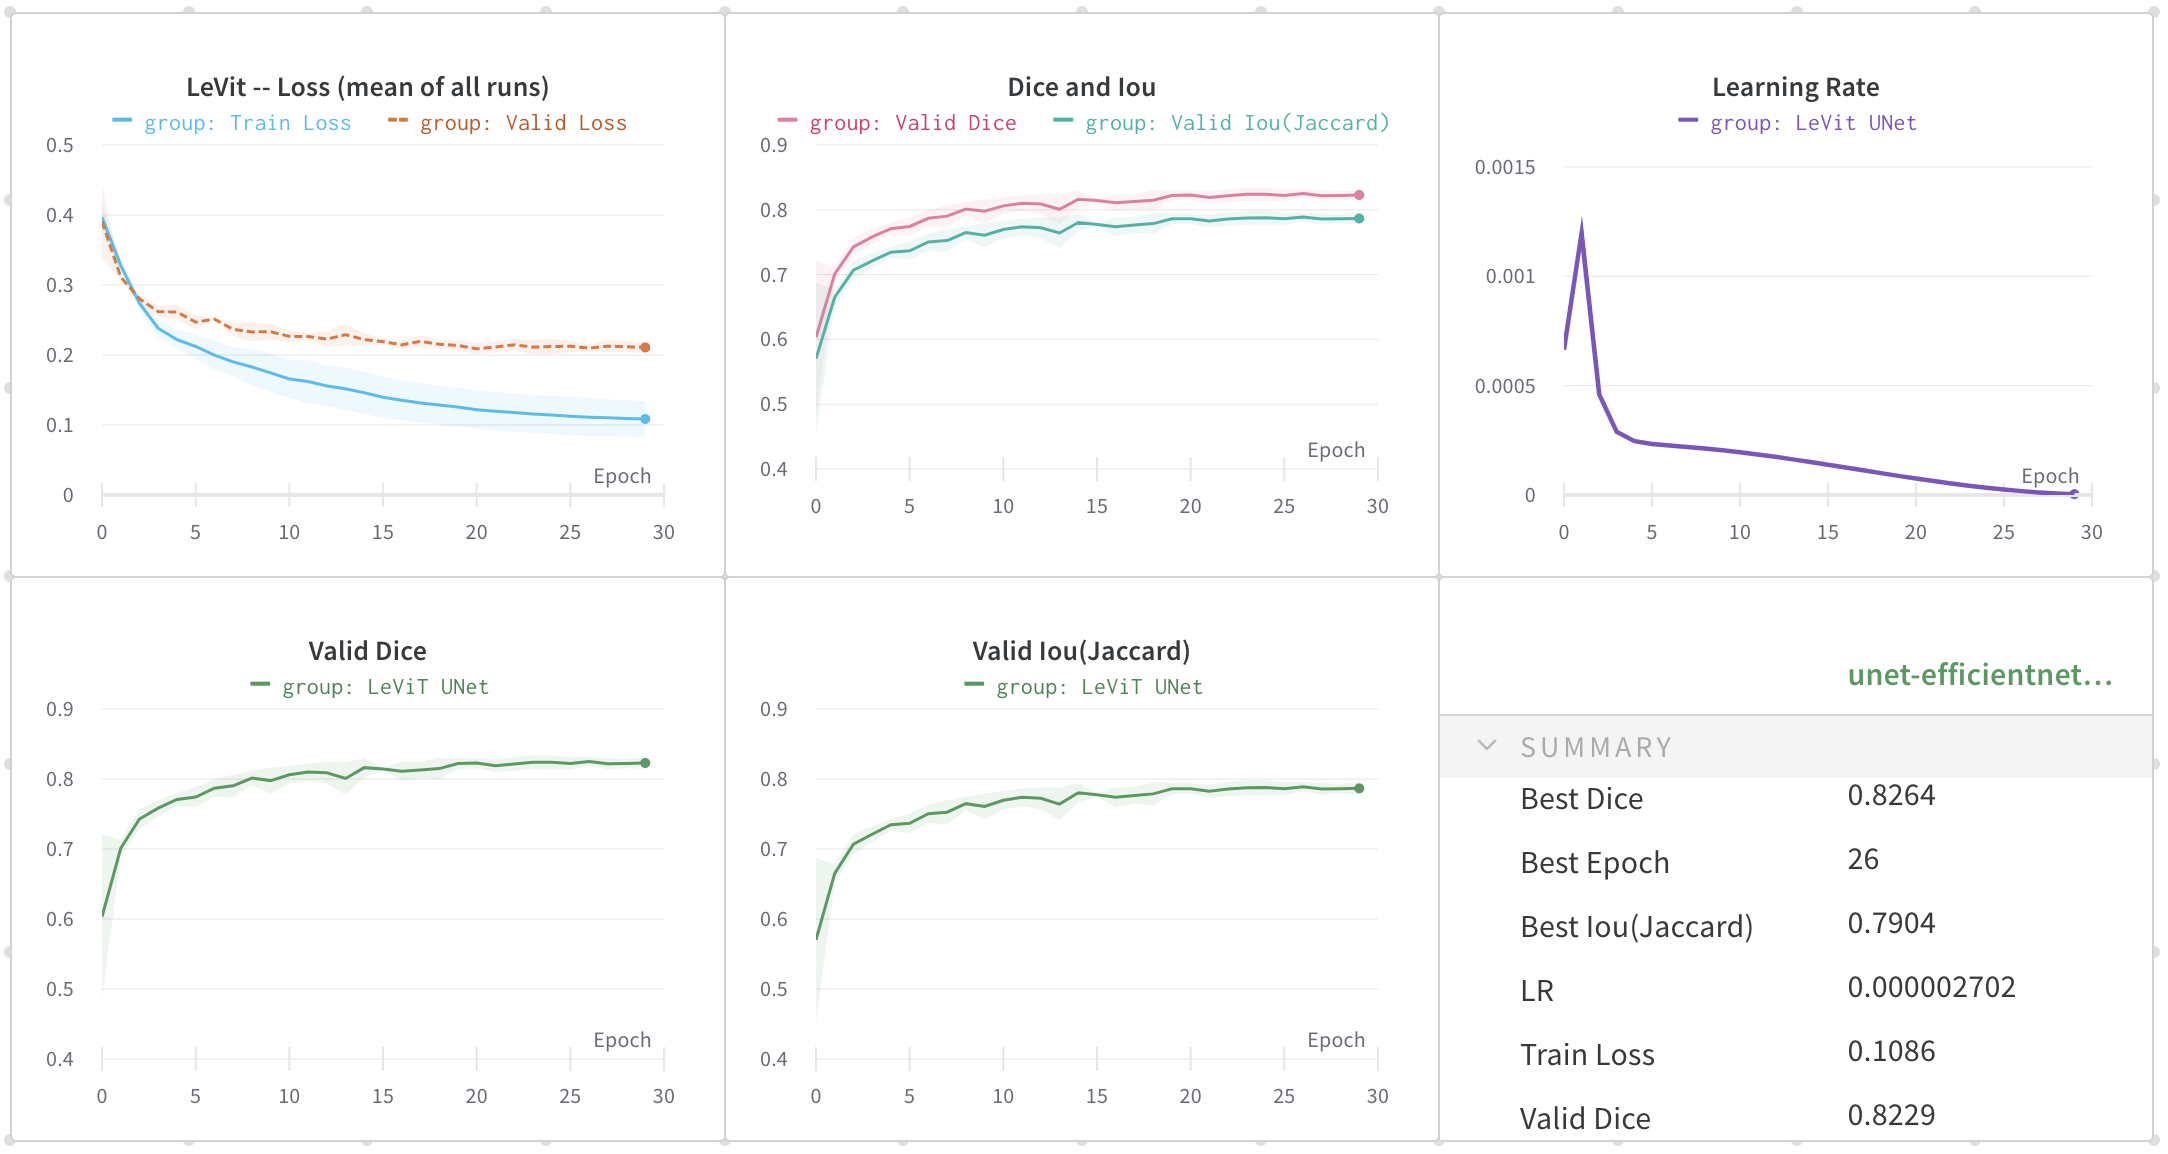

The results of LeViT are not as ideal as UNet's, with both training and validation losses being about 0.1 higher than UNet's after the same number of training iterations.  Additionally, the Dice score of LeViT also did not reach the best score achieved by UNet. 

One possible reason for the lower performance could be the difference in input shape - LeViT takes in a single-channel grayscale image while UNet takes in a three-channel RGB image. The difference in input format can affect the model's ability to extract features from the image.

>LeViT UNet ----<br>
Best Dice: 0.8264<br>
Best Iou: 0.7904<br>
Best Train Loss: 0.1086<br>
Best Valid Loss: 0.2024 <br>

In [ ]:
import gc
gc.collect()

39

In [ ]:
#@title Testing
'''
############################
LeVit Unet Testing 
############################
'''
test_dataset = MyDataset(df_folds[(df_folds['fold'] == 0) & (df_folds['empty'] == 0)].sample(frac=1.0), label=False, 
                            trans=val_trans(opt2), rgb=False)
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(opt2.device, dtype=torch.float)

preds = []
for fold in range(1):
    model2_test = Build_LeViT_UNet_384(pretrained=True, num_classes=opt2.num_classes)
    model2_test.to(device)
    model2_test.load_state_dict(torch.load(MODEL_PATH+'/'+opt2.model_name+f"/best_epoch-{fold:02d}.pth"))
    model2_test.eval()
    
    with torch.no_grad():
        pred = model2_test(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

0
1
2
1:  block_1.0.m.attention_biases
1:  block_1.0.m.attention_bias_idxs
1:  block_1.0.m.qkv.c.weight
1:  block_1.0.m.qkv.bn.weight
1:  block_1.0.m.qkv.bn.bias
1:  block_1.0.m.qkv.bn.running_mean
1:  block_1.0.m.qkv.bn.running_var
1:  block_1.0.m.qkv.bn.num_batches_tracked
1:  block_1.0.m.proj.1.c.weight
1:  block_1.0.m.proj.1.bn.weight
1:  block_1.0.m.proj.1.bn.bias
1:  block_1.0.m.proj.1.bn.running_mean
1:  block_1.0.m.proj.1.bn.running_var
1:  block_1.0.m.proj.1.bn.num_batches_tracked
1:  block_1.1.m.0.c.weight
1:  block_1.1.m.0.bn.weight
1:  block_1.1.m.0.bn.bias
1:  block_1.1.m.0.bn.running_mean
1:  block_1.1.m.0.bn.running_var
1:  block_1.1.m.0.bn.num_batches_tracked
1:  block_1.1.m.2.c.weight
1:  block_1.1.m.2.bn.weight
1:  block_1.1.m.2.bn.bias
1:  block_1.1.m.2.bn.running_mean
1:  block_1.1.m.2.bn.running_var
1:  block_1.1.m.2.bn.num_batches_tracked
1:  block_1.2.m.attention_biases
1:  block_1.2.m.attention_bias_idxs
1:  block_1.2.m.qkv.c.weight
1:  block_1.2.m.qkv.bn.weight

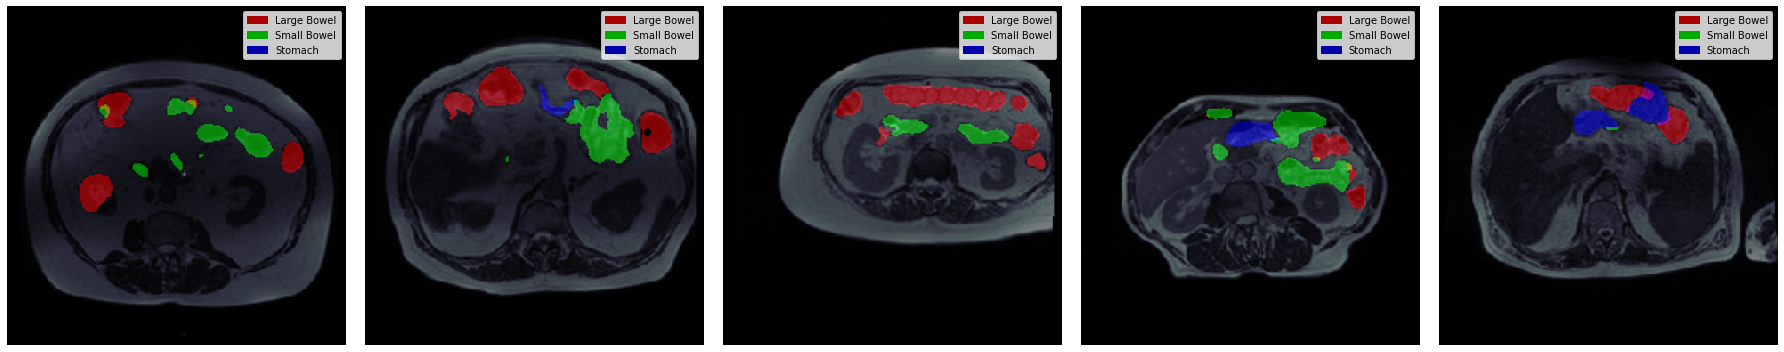

In [ ]:
# Predicting results
plot_batch(imgs, preds, size=5)

# Two Fine-Tuned Model
 --- Mainly based on Attention and Transformer machineism

# Model3 - Transformer UNet


In order to further test the effectiveness of Transformer in UNet, we modified the model by following: Instead of fully connection layers in each stage of U-net, we apply Transformer blocks to perform feature extraction and reconstruction. The overall pipeline can still be divided into two parts: Down-sample Encoder and Up-sample Decoder.

This approach aims to leverage the self-attention mechanism of the Transformer to improve feature extraction and enhance the accuracy of segmentation tasks. Additionally, we using a different scheduler this time: `ReduceLROnPlateau` which could also help improve the model's training efficiency and convergence.

Overall, this new approach could potentially lead to better performance in image segmentation tasks, and we look forward to analyzing the results to evaluate its effectiveness.

In [ ]:
#@title Artichtecture Modification
import segmentation_models_pytorch as smp
import torch.nn as nn

class TransformerUnet(smp.Unet):
    def __init__(self, dim, heads, layers, mlp_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.heads = heads
        self.layers = layers
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def _make_encoder(self, **kwargs):
        encoder = smp.encoders.get_encoder(self.encoder_name, **kwargs)
        in_channels = self.in_channels

        # Replace CNN encoder layers with Transformer encoder layers
        encoder_blocks = []
        for block in encoder.blocks:
            transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=self.dim, nhead=self.heads, dim_feedforward=self.mlp_dim, dropout=self.dropout)
            transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=self.layers)
            encoder_blocks.append(transformer_encoder)
            in_channels = block.out_channels

        self.encoder = nn.Sequential(*encoder_blocks)
        self.encoder.out_channels = in_channels

        # Reinitialize classification head to match new output channels
        self._init_classifier(self.encoder.out_channels, self.classes)

        return self.encoder


In [ ]:
#@title Configuration
import gc
gc.collect()

'''
############################
Transformer UNet Model Preparation
############################
'''

############ Model #############
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt3 = Options()
opt3.model_name = 'TransformerUnet'
opt3.train_bs = 128     # 64
opt3.scheduler = 'ReduceLROnPlateau'
opt3.warmup_epochs = 3
opt3.epochs = 30
opt3.n_fold = 5

# Create the TransformerUnet model
model3 = TransformerUnet(dim=224, heads=8, layers=6, mlp_dim=1024, dropout=0.1, 
                        encoder_name=opt3.backbone, encoder_weights='imagenet', 
                        in_channels=3, classes=opt3.num_classes, activation=None)
                                    
model3.to(device)

optimizer = optim.AdamW(model3.parameters(), lr=opt3.lr, weight_decay=opt3.wd)
scheduler = fetch_scheduler(opt3, optimizer)


In [ ]:
#@title Training
'''
############################
Transformer Unet Training 
############################
'''
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='model-TransformerUnet', 
                     config={k:v for k, v in dict(vars(opt3)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{opt3.img_size[0]}x{opt3.img_size[1]}|model-{opt3.model_name}",
                     group=opt3.comment,
                    )
    train_loader, valid_loader, t_len, v_len = MyLoaders(df=df_folds, fold=fold, opt_=opt3, debug=opt3.debug)
    # model     = build_model()
    optimizer = optim.AdamW(model3.parameters(), lr=opt3.lr, weight_decay=opt3.wd)
    scheduler = fetch_scheduler(opt3, optimizer)
    model, history = run_training(model3, optimizer, scheduler,opt3)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: NVIDIA A100-SXM4-40GB

Epoch 1/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:18<00:00,  1.48it/s, gpu_memory=18.36 GB, lr=0.00066, valid_loss=0.3643]


Valid Dice: 0.6880 | Valid Iou(Jaccard): 0.6607
Valid Score Improved (-inf ---> 0.6880)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 2/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:17<00:00,  1.58it/s, gpu_memory=14.54 GB, lr=0.00133, valid_loss=0.2083]


Valid Dice: 0.5959 | Valid Iou(Jaccard): 0.5596


Epoch 3/30



Train :   0%|          | 0/248 [00:00<?, ?it/s]


>>>>>>>>>>>> Warming up >>>>>>>>>>>>


Valid : 100%|██████████| 27/27 [00:17<00:00,  1.56it/s, gpu_memory=14.51 GB, lr=0.00067, valid_loss=0.1495]


Valid Dice: 0.8413 | Valid Iou(Jaccard): 0.8092
Valid Score Improved (0.6880 ---> 0.8413)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 4/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.68it/s, gpu_memory=14.50 GB, lr=0.00000, valid_loss=0.1441]


Valid Dice: 0.8737 | Valid Iou(Jaccard): 0.8408
Valid Score Improved (0.8413 ---> 0.8737)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 5/30



Valid : 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, gpu_memory=14.50 GB, lr=0.00000, valid_loss=0.1432]


Valid Dice: 0.8765 | Valid Iou(Jaccard): 0.8441
Valid Score Improved (0.8737 ---> 0.8765)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 6/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.65it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1428]


Valid Dice: 0.8772 | Valid Iou(Jaccard): 0.8449
Valid Score Improved (0.8765 ---> 0.8772)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 7/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.71it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1423]


Valid Dice: 0.8777 | Valid Iou(Jaccard): 0.8455
Valid Score Improved (0.8772 ---> 0.8777)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 8/30



Valid : 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1419]


Valid Dice: 0.8779 | Valid Iou(Jaccard): 0.8457
Valid Score Improved (0.8777 ---> 0.8779)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 9/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1417]


Valid Dice: 0.8791 | Valid Iou(Jaccard): 0.8470
Valid Score Improved (0.8779 ---> 0.8791)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 10/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.72it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1414]


Valid Dice: 0.8794 | Valid Iou(Jaccard): 0.8474
Valid Score Improved (0.8791 ---> 0.8794)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 11/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1411]


Valid Dice: 0.8797 | Valid Iou(Jaccard): 0.8477
Valid Score Improved (0.8794 ---> 0.8797)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 12/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.46it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1410]


Valid Dice: 0.8806 | Valid Iou(Jaccard): 0.8487
Valid Score Improved (0.8797 ---> 0.8806)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 13/30



Valid : 100%|██████████| 27/27 [00:13<00:00,  1.94it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1409]


Valid Dice: 0.8803 | Valid Iou(Jaccard): 0.8484


Epoch 14/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.69it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1407]


Valid Dice: 0.8812 | Valid Iou(Jaccard): 0.8493
Valid Score Improved (0.8806 ---> 0.8812)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 15/30



Valid : 100%|██████████| 27/27 [00:17<00:00,  1.53it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1404]


Valid Dice: 0.8801 | Valid Iou(Jaccard): 0.8482


Epoch 16/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.68it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1403]


Valid Dice: 0.8812 | Valid Iou(Jaccard): 0.8494
Valid Score Improved (0.8812 ---> 0.8812)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 17/30



Valid : 100%|██████████| 27/27 [00:17<00:00,  1.52it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1401]


Valid Dice: 0.8817 | Valid Iou(Jaccard): 0.8499
Valid Score Improved (0.8812 ---> 0.8817)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 18/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1401]


Valid Dice: 0.8811 | Valid Iou(Jaccard): 0.8492


Epoch 19/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.48it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1401]


Valid Dice: 0.8819 | Valid Iou(Jaccard): 0.8501
Valid Score Improved (0.8817 ---> 0.8819)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 20/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.72it/s, gpu_memory=14.52 GB, lr=0.00000, valid_loss=0.1399]


Valid Dice: 0.8813 | Valid Iou(Jaccard): 0.8495


Epoch 21/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.71it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1398]


Valid Dice: 0.8819 | Valid Iou(Jaccard): 0.8501
Valid Score Improved (0.8819 ---> 0.8819)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 22/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1400]


Valid Dice: 0.8830 | Valid Iou(Jaccard): 0.8514
Valid Score Improved (0.8819 ---> 0.8830)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 23/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.66it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1397]


Valid Dice: 0.8815 | Valid Iou(Jaccard): 0.8498


Epoch 24/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.68it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1398]


Valid Dice: 0.8812 | Valid Iou(Jaccard): 0.8495


Epoch 25/30



Valid : 100%|██████████| 27/27 [00:15<00:00,  1.69it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1396]


Valid Dice: 0.8822 | Valid Iou(Jaccard): 0.8505


Epoch 26/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.45it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1395]


Valid Dice: 0.8813 | Valid Iou(Jaccard): 0.8495


Epoch 27/30



Valid : 100%|██████████| 27/27 [00:18<00:00,  1.44it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1394]


Valid Dice: 0.8815 | Valid Iou(Jaccard): 0.8498


Epoch 28/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.68it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1393]


Valid Dice: 0.8827 | Valid Iou(Jaccard): 0.8511


Epoch 29/30



Valid : 100%|██████████| 27/27 [00:17<00:00,  1.52it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1395]


Valid Dice: 0.8828 | Valid Iou(Jaccard): 0.8513


Epoch 30/30



Valid : 100%|██████████| 27/27 [00:16<00:00,  1.66it/s, gpu_memory=14.51 GB, lr=0.00000, valid_loss=0.1395]


Valid Dice: 0.8839 | Valid Iou(Jaccard): 0.8524
Valid Score Improved (0.8830 ---> 0.8839)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Training complete in 1h 59m 59s
Best Score: 0.8524


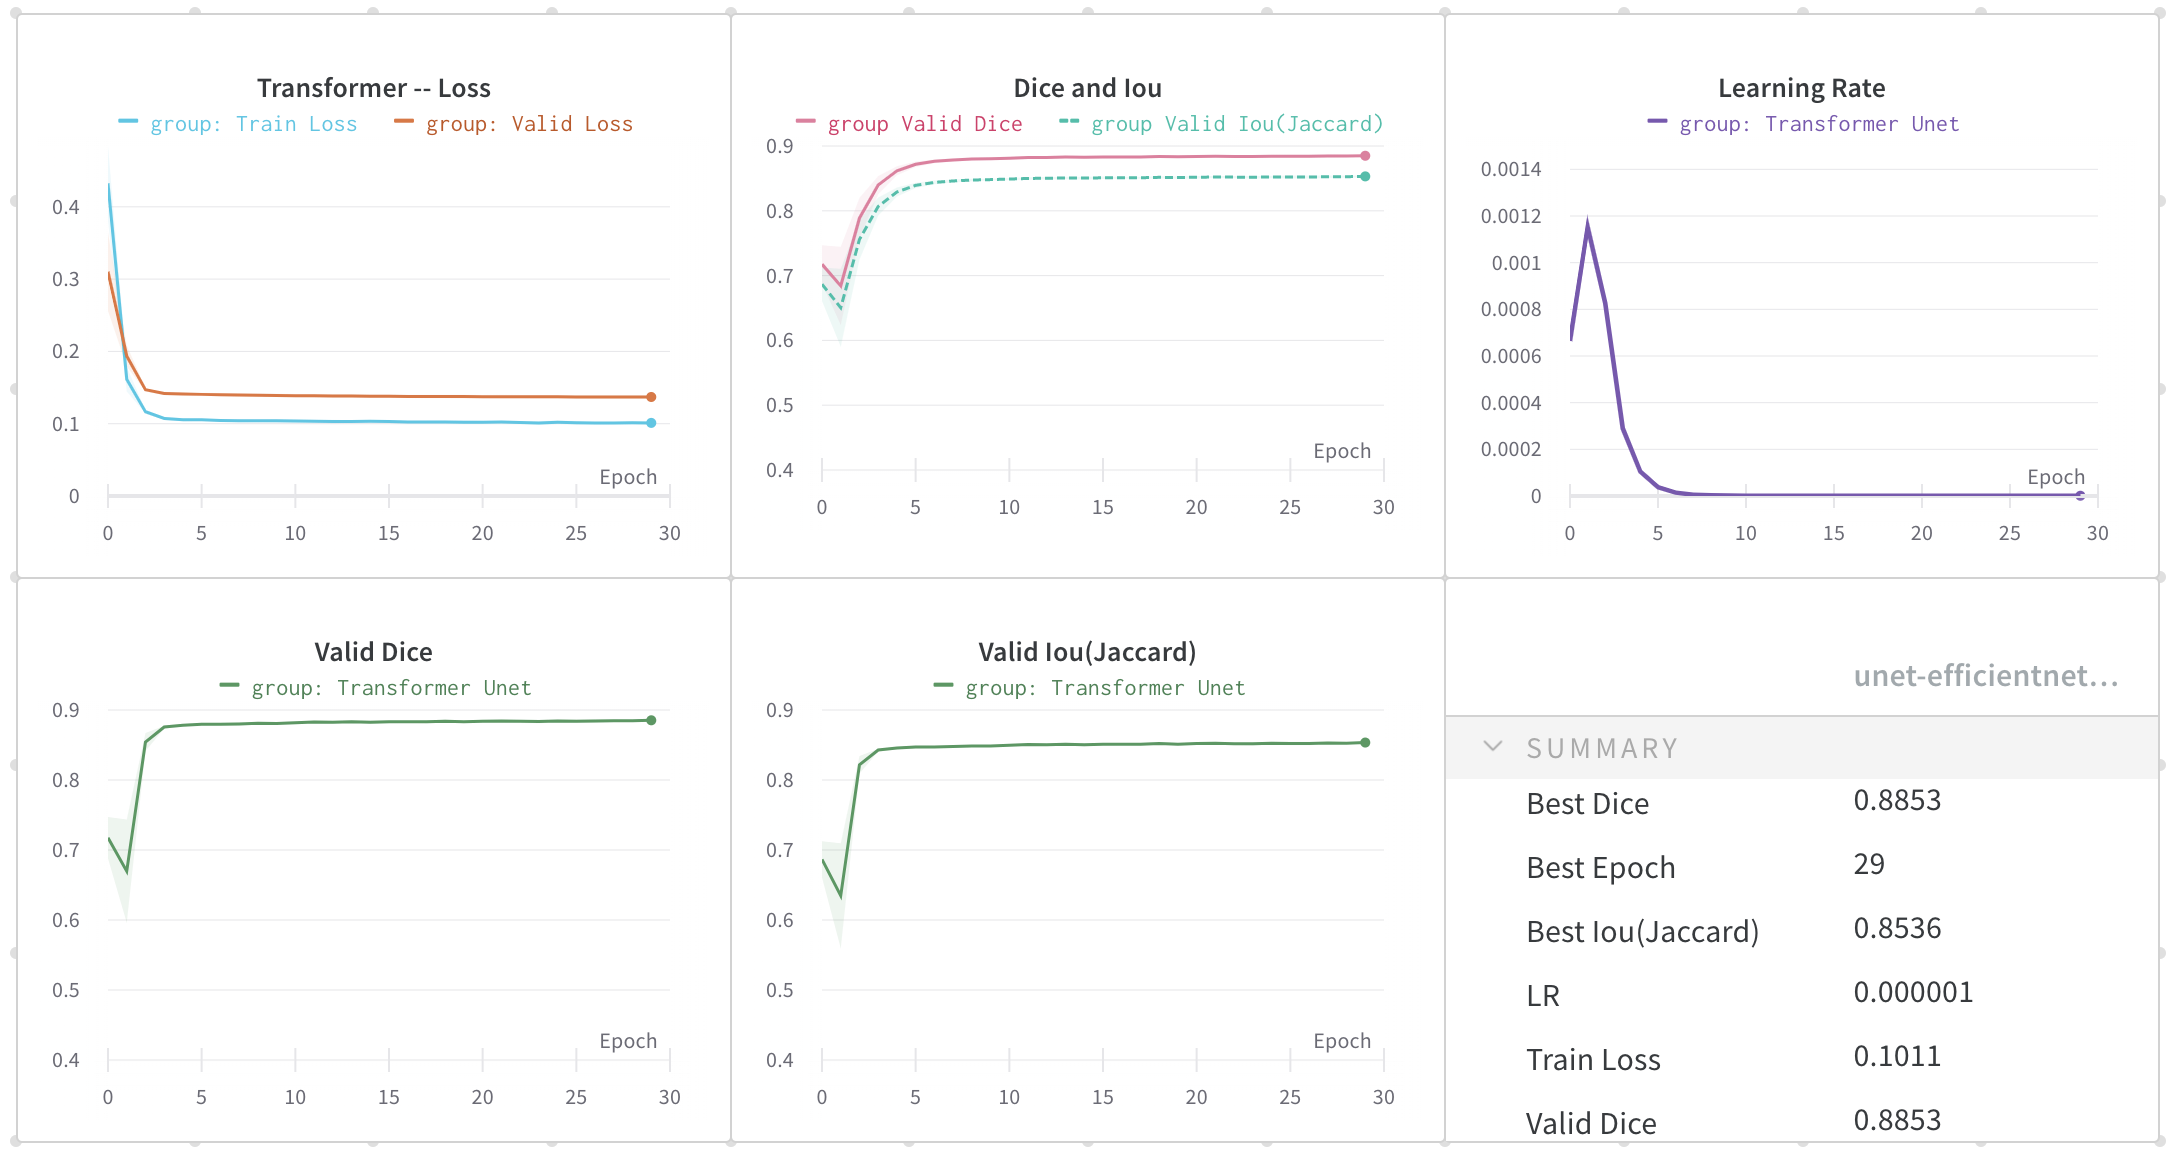

The results show that replacing both the encoder and decoder structures of UNet with Transformer blocks is indeed more effective. The model's Dice and IoU scores increased to nearly 0.9. Additionally, the changes in loss for the training and validation sets became closer, indicating that the model's generalization ability has improved, thus avoiding overfitting.

It is worth noting the learning rate curve on the right-hand side of the graph. Compared to the previous approach, the learning rate in this approach, ReduceLROnPlateau, decreases faster and reaches near-zero at the 6th epoch. This suggests that the optimization process of the model has improved, allowing it to converge faster and reach higher performance.

In [ ]:
#@title Testing
'''
############################
Transformer Unet Testing 
############################
'''
test_dataset = MyDataset(df_folds[(df_folds['fold'] == 0) & (df_folds['empty'] == 0)].sample(frac=1.0), label=False, 
                            trans=val_trans(opt3))
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(opt3.device, dtype=torch.float)

preds = []
for fold in range(1):
    model3_test = TransformerUnet(dim=224, heads=8, layers=6, mlp_dim=1024, dropout=0.1, 
                        encoder_name=opt3.backbone, encoder_weights='imagenet', 
                        in_channels=3, classes=opt3.num_classes, activation=None)
    model3_test.to(device)
    model3_test.load_state_dict(torch.load(MODEL_PATH+f"/TransformerUnet/best_epoch-{fold:02d}.pth"))
    model3_test.eval()
    
    with torch.no_grad():
        pred = model3_test(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

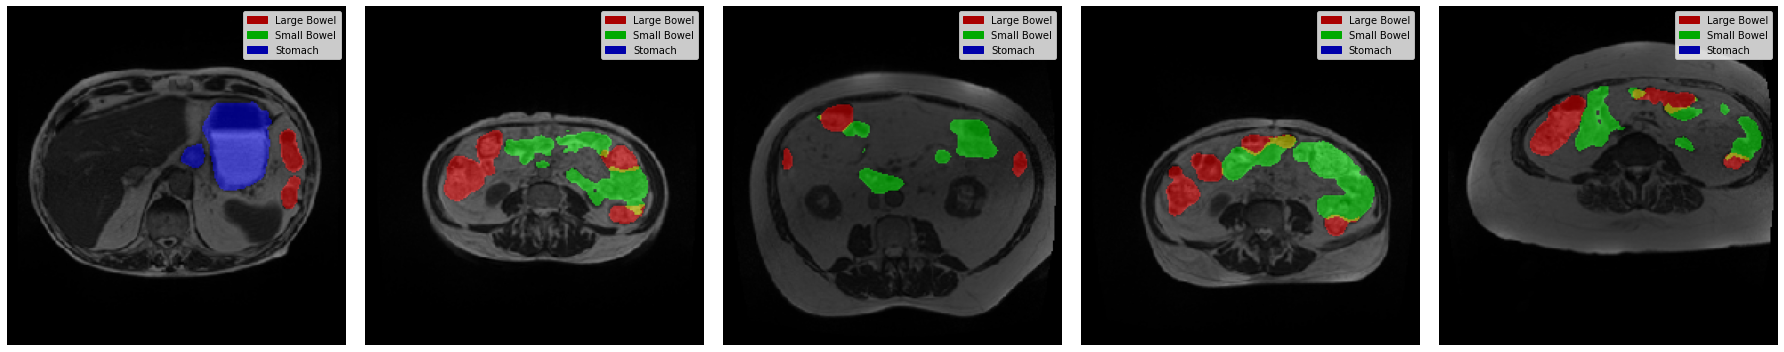

In [ ]:
# Predicting results
plot_batch(imgs, preds, size=5)

In [ ]:
# Predicting results
plot_batch(imgs, preds, size=5)

# Model4 - SwinTransformer-backed UNet

Finally, I attempted to apply the Swin Transformer-Unet that I had previously implemented on to current task. The Swin Transformer is an extension of the traditional Transformer and can be utilized as a feature extractor in the field of Computer Vision, similar to a CNN, but has high computation requirements. I ran this model on an A100 GPU-based server, however it seems not the best choice. 

In [ ]:
#@title SwinTransformer-backed UNet Implementation

'''
SwinTransformer based UNet

Updated 2022/3/8 By Aurora
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from einops import rearrange, repeat
import math

#########################################
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(ConvBlock, self).__init__()
        self.strides = strides
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.conv11 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides, padding=0)

    def forward(self, x):
        out1 = self.block(x)
        out2 = self.conv11(x)
        out = out1 + out2
        return out


class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: [B, N, C]
        x = torch.transpose(x, 1, 2)  # [B, C, N]
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        x = x * y.expand_as(x)
        x = torch.transpose(x, 1, 2)  # [B, N, C]
        return x


class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1, act_layer=nn.ReLU):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.act_layer = act_layer() if act_layer is not None else nn.Identity()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        x = self.depthwise(x)
        x = self.act_layer(x)
        x = self.pointwise(x)
        return x

#########################################
######## Embedding for q,k,v ########
class ConvProjection(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout=0.,
                 last_stage=False, bias=True):
        super().__init__()

        inner_dim = dim_head * heads
        self.heads = heads
        pad = (kernel_size - q_stride) // 2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad, bias)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad, bias)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad, bias)

    def forward(self, x, attn_kv=None):
        b, n, c, h = *x.shape, self.heads
        l = int(math.sqrt(n))
        w = int(math.sqrt(n))

        attn_kv = x if attn_kv is None else attn_kv
        x = rearrange(x, 'b (l w) c -> b c l w', l=l, w=w)
        attn_kv = rearrange(attn_kv, 'b (l w) c -> b c l w', l=l, w=w)
        # print(attn_kv)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

        k = self.to_k(attn_kv)
        v = self.to_v(attn_kv)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)
        return q, k, v

    def flops(self, H, W):
        flops = 0
        flops += self.to_q.flops(H, W)
        flops += self.to_k.flops(H, W)
        flops += self.to_v.flops(H, W)
        return flops


class LinearProjection(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0., bias=True):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.to_q = nn.Linear(dim, inner_dim, bias=bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=bias)
        self.dim = dim
        self.inner_dim = inner_dim

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        attn_kv = x if attn_kv is None else attn_kv
        q = self.to_q(x).reshape(B_, N, 1, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv = self.to_kv(attn_kv).reshape(B_, N, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q = q[0]
        k, v = kv[0], kv[1]
        return q, k, v

    def flops(self, H, W):
        flops = H * W * self.dim * self.inner_dim * 3
        return flops


class LinearProjection_Concat_kv(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0., bias=True):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=bias)
        self.dim = dim
        self.inner_dim = inner_dim

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        attn_kv = x if attn_kv is None else attn_kv
        qkv_dec = self.to_qkv(x).reshape(B_, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv_enc = self.to_kv(attn_kv).reshape(B_, N, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k_d, v_d = qkv_dec[0], qkv_dec[1], qkv_dec[2]  # make torchscript happy (cannot use tensor as tuple)
        k_e, v_e = kv_enc[0], kv_enc[1]
        k = torch.cat((k_d, k_e), dim=2)
        v = torch.cat((v_d, v_e), dim=2)
        return q, k, v

    def flops(self, H, W):
        flops = H * W * self.dim * self.inner_dim * 5
        return flops

    #########################################


########### window-based self-attention #############
class WindowAttention(nn.Module):
    def __init__(self, dim, win_size, num_heads, token_projection='linear', qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0., se_layer=False):

        super().__init__()
        self.dim = dim
        self.win_size = win_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * win_size[0] - 1) * (2 * win_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.win_size[0])  # [0,...,Wh-1]
        coords_w = torch.arange(self.win_size[1])  # [0,...,Ww-1]
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.win_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.win_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.win_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        # self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        if token_projection == 'conv':
            self.qkv = ConvProjection(dim, num_heads, dim // num_heads, bias=qkv_bias)
        elif token_projection == 'linear_concat':
            self.qkv = LinearProjection_Concat_kv(dim, num_heads, dim // num_heads, bias=qkv_bias)
        else:
            self.qkv = LinearProjection(dim, num_heads, dim // num_heads, bias=qkv_bias)

        self.token_projection = token_projection
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.se_layer = SELayer(dim) if se_layer else nn.Identity()
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attn_kv=None, mask=None):
        B_, N, C = x.shape
        q, k, v = self.qkv(x, attn_kv)
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.win_size[0] * self.win_size[1], self.win_size[0] * self.win_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        ratio = attn.size(-1) // relative_position_bias.size(-1)
        relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d=ratio)

        attn = attn + relative_position_bias.unsqueeze(0)

        # SW-MSA
        if mask is not None:
            nW = mask.shape[0]
            mask = repeat(mask, 'nW m n -> nW m (n d)', d=ratio)
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N * ratio) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N * ratio)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.se_layer(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, win_size={self.win_size}, num_heads={self.num_heads}'


#########################################
########### feed-forward network #############
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



class FFN(nn.Module):
    def __init__(self, dim=32, hidden_dim=128, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(dim, hidden_dim),
                                     act_layer())
        self.dwconv = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, groups=hidden_dim, kernel_size=3, stride=1, padding=1),
            act_layer())
        self.linear2 = nn.Sequential(nn.Linear(hidden_dim, dim))
        self.dim = dim
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # bs x hw x c
        bs, hw, c = x.size()
        hh = int(math.sqrt(hw))

        x = self.linear1(x)

        # spatial restore
        x = rearrange(x, ' b (h w) (c) -> b c h w ', h=hh, w=hh)
        # x = rearrange(x, ' b (h w) (c) -> b c h w ', h=height, w=int(hw/height))

        # bs,hidden_dim,32x32
        x = self.dwconv(x)

        # flaten
        x = rearrange(x, ' b c h w -> b (h w) c', h=hh, w=hh)
        # x = rearrange(x, ' b c h w -> b (h w) c', h=height, w=int(hw/height))


        x = self.linear2(x)

        return x


#########################################
########### window operation#############
def window_partition(x, win_size, dilation_rate=1):
    B, H, W, C = x.shape
    # print()
    # print(x.shape)
    if dilation_rate != 1:
        x = x.permute(0, 3, 1, 2)  # B, C, H, W
        assert type(dilation_rate) is int, 'dilation_rate should be a int'
        x = F.unfold(x, kernel_size=win_size, dilation=dilation_rate, padding=4 * (dilation_rate - 1),
                     stride=win_size)  # B, C*Wh*Ww, H/Wh*W/Ww
        windows = x.permute(0, 2, 1).contiguous().view(-1, C, win_size, win_size)  # B' ,C ,Wh ,Ww
        windows = windows.permute(0, 2, 3, 1).contiguous()  # B' ,Wh ,Ww ,C
    else:
        x = x.view(B, H // win_size, win_size, W // win_size, win_size, C)
        # print("ok")
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, win_size, win_size, C)  # B' ,Wh ,Ww ,C
    return windows


def window_reverse(windows, win_size, H, W, dilation_rate=1):
    # B' ,Wh ,Ww ,C
    B = int(windows.shape[0] / (H * W / win_size / win_size))
    x = windows.view(B, H // win_size, W // win_size, win_size, win_size, -1)
    if dilation_rate != 1:
        x = windows.permute(0, 5, 3, 4, 1, 2).contiguous()  # B, C*Wh*Ww, H/Wh*W/Ww
        x = F.fold(x, (H, W), kernel_size=win_size, dilation=dilation_rate, padding=4 * (dilation_rate - 1),
                   stride=win_size)
    else:
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


#########################################
# Downsample Block
class Downsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downsample, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1),
        )
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, L, C = x.shape
        # import pdb;pdb.set_trace()
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).contiguous().view(B, C, H, W)
        out = self.conv(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C
        return out


# Upsample Block
class Upsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Upsample, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
        )
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).contiguous().view(B, C, H, W)
        out = self.deconv(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C
        return out


# Input conv -> shallow features
class InputConv(nn.Module):
    def __init__(self, in_channel=3, out_channel=64, kernel_size=3, stride=1, norm_layer=None, act_layer=nn.LeakyReLU):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=kernel_size // 2),
            act_layer(inplace=True)
        )
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C
        if self.norm is not None:
            x = self.norm(x)
        return x


# Output Conv -> to 3 channel
class OutputConv(nn.Module):
    def __init__(self, in_channel=64, out_channel=3, kernel_size=3, stride=1, norm_layer=None, act_layer=None):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=kernel_size // 2),
        )
        if act_layer is not None:
            self.proj.add_module(act_layer(inplace=True))
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None
        self.in_channel = in_channel
        self.out_channel = out_channel

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.proj(x)
        if self.norm is not None:
            x = self.norm(x)
        return x


#########################################
########### SwinTransformerBlock #############
class SwinTransBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, win_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, token_projection='linear', token_mlp='FFN',
                 se_layer=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.win_size = win_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.token_mlp = token_mlp
        if min(self.input_resolution) <= self.win_size:
            self.shift_size = 0
            self.win_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.win_size, "shift_size must in 0-win_size"

        # self.resweight = nn.Parameter(torch.Tensor([0])) #######

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, win_size=to_2tuple(self.win_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            token_projection=token_projection, se_layer=se_layer)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer,
                       drop=drop) if token_mlp == 'ffn' else FFN(dim, mlp_hidden_dim, act_layer=act_layer, drop=drop) ##

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"win_size={self.win_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def forward(self, x, mask=None):
        # print("\n")
        # print(x.shape)
        # print(x.size)

        B, L, C = x.shape

        # H = int(height)
        # W = int(L/height)
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        # print("H=%d, W=%d" % (H, W))
        # print("\n")

        ## input mask
        if mask != None:
            input_mask = F.interpolate(mask, size=(H, W)).permute(0, 2, 3, 1)
            input_mask_windows = window_partition(input_mask, self.win_size)  # nW, win_size, win_size, 1
            attn_mask = input_mask_windows.view(-1, self.win_size * self.win_size)  # nW, win_size*win_size
            attn_mask = attn_mask.unsqueeze(2) * attn_mask.unsqueeze(1)  # nW, win_size*win_size, win_size*win_size
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.win_size),
                        slice(-self.win_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_windows = window_partition(shift_mask, self.win_size)  # nW, win_size, win_size, 1
            shift_mask_windows = shift_mask_windows.view(-1, self.win_size * self.win_size)  # nW, win_size*win_size
            shift_attn_mask = shift_mask_windows.unsqueeze(1) - shift_mask_windows.unsqueeze(
                2)  # nW, win_size*win_size, win_size*win_size
            shift_attn_mask = shift_attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0)).masked_fill(
                shift_attn_mask == 0, float(0.0))
            attn_mask = attn_mask + shift_attn_mask if attn_mask is not None else shift_attn_mask

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.win_size)  # nW*B, win_size, win_size, C  N*C->C
        x_windows = x_windows.view(-1, self.win_size * self.win_size, C)  # nW*B, win_size*win_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, win_size*win_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.win_size, self.win_size, C)
        shifted_x = window_reverse(attn_windows, self.win_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        # x = x + self.drop_path(self.mlp(self.norm2(x), height)) ##
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        del attn_mask
        return x


#########################################
########### Basic layer of AtUNet ################
class BasicAtUNetLayer(nn.Module):
    def __init__(self, dim, output_dim, input_resolution, depth, num_heads, win_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, use_checkpoint=False,
                 token_projection='linear', token_mlp='ffn', se_layer=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransBlock(dim=dim, input_resolution=input_resolution,
                                  num_heads=num_heads, win_size=win_size,
                                  shift_size=0 if (i % 2 == 0) else win_size // 2,
                                  mlp_ratio=mlp_ratio,
                                  qkv_bias=qkv_bias, qk_scale=qk_scale,
                                  drop=drop, attn_drop=attn_drop,
                                  drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                  norm_layer=norm_layer, token_projection=token_projection, token_mlp=token_mlp,
                                  se_layer=se_layer)
            for i in range(depth)])

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def forward(self, x, mask=None):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x, mask)
        return x


class AtUNet(nn.Module):
    def __init__(self, img_size=128, in_chans=3,
                 embed_dim=32, depths=[2, 2, 2, 2, 2, 2, 2, 2, 2], num_heads=[1, 2, 4, 8, 16, 16, 8, 4, 2],
                 win_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, token_projection='linear', token_mlp='ffn', se_layer=False,
                 dowsample=Downsample, upsample=Upsample, **kwargs):
        super().__init__()

        self.num_enc_layers = len(depths) // 2
        self.num_dec_layers = len(depths) // 2
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.mlp_ratio = mlp_ratio
        self.token_projection = token_projection
        self.mlp = token_mlp
        self.win_size = win_size
        self.reso = img_size
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        enc_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths[:self.num_enc_layers]))]
        conv_dpr = [drop_path_rate] * depths[4]
        dec_dpr = enc_dpr[::-1]

        # build layers

        # Input/Output
        self.input_proj = InputConv(in_channel=in_chans, out_channel=embed_dim, kernel_size=3, stride=1,
                                    act_layer=nn.LeakyReLU)
        self.output_proj = OutputConv(in_channel=2 * embed_dim, out_channel=in_chans, kernel_size=3, stride=1)

        # Encoder
        self.encoderlayer_0 = BasicAtUNetLayer(dim=embed_dim,
                                                output_dim=embed_dim,
                                                input_resolution=(img_size,
                                                                  img_size),
                                                depth=depths[0],
                                                num_heads=num_heads[0],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=enc_dpr[sum(depths[:0]):sum(depths[:1])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.dowsample_0 = dowsample(embed_dim, embed_dim * 2)
        self.encoderlayer_1 = BasicAtUNetLayer(dim=embed_dim * 2,
                                                output_dim=embed_dim * 2,
                                                input_resolution=(img_size // 2,
                                                                  img_size // 2),
                                                depth=depths[1],
                                                num_heads=num_heads[1],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=enc_dpr[sum(depths[:1]):sum(depths[:2])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.dowsample_1 = dowsample(embed_dim * 2, embed_dim * 4)
        self.encoderlayer_2 = BasicAtUNetLayer(dim=embed_dim * 4,
                                                output_dim=embed_dim * 4,
                                                input_resolution=(img_size // (2 ** 2),
                                                                  img_size // (2 ** 2)),
                                                depth=depths[2],
                                                num_heads=num_heads[2],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=enc_dpr[sum(depths[:2]):sum(depths[:3])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.dowsample_2 = dowsample(embed_dim * 4, embed_dim * 8)
        self.encoderlayer_3 = BasicAtUNetLayer(dim=embed_dim * 8,
                                                output_dim=embed_dim * 8,
                                                input_resolution=(img_size // (2 ** 3),
                                                                  img_size // (2 ** 3)),
                                                depth=depths[3],
                                                num_heads=num_heads[3],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=enc_dpr[sum(depths[:3]):sum(depths[:4])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.dowsample_3 = dowsample(embed_dim * 8, embed_dim * 16)

        # Bottleneck
        self.conv = BasicAtUNetLayer(dim=embed_dim * 16,
                                      output_dim=embed_dim * 16,
                                      input_resolution=(img_size // (2 ** 4),
                                                        img_size // (2 ** 4)),
                                      depth=depths[4],
                                      num_heads=num_heads[4],
                                      win_size=win_size,
                                      mlp_ratio=self.mlp_ratio,
                                      qkv_bias=qkv_bias, qk_scale=qk_scale,
                                      drop=drop_rate, attn_drop=attn_drop_rate,
                                      drop_path=conv_dpr,
                                      norm_layer=norm_layer,
                                      use_checkpoint=use_checkpoint,
                                      token_projection=token_projection, token_mlp=token_mlp, se_layer=se_layer)

        # Decoder
        self.upsample_0 = upsample(embed_dim * 16, embed_dim * 8)
        self.decoderlayer_0 = BasicAtUNetLayer(dim=embed_dim * 16,
                                                output_dim=embed_dim * 16,
                                                input_resolution=(img_size // (2 ** 3),
                                                                  img_size // (2 ** 3)),
                                                depth=depths[5],
                                                num_heads=num_heads[5],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=dec_dpr[:depths[5]],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.upsample_1 = upsample(embed_dim * 16, embed_dim * 4)
        self.decoderlayer_1 = BasicAtUNetLayer(dim=embed_dim * 8,
                                                output_dim=embed_dim * 8,
                                                input_resolution=(img_size // (2 ** 2),
                                                                  img_size // (2 ** 2)),
                                                depth=depths[6],
                                                num_heads=num_heads[6],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=dec_dpr[sum(depths[5:6]):sum(depths[5:7])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.upsample_2 = upsample(embed_dim * 8, embed_dim * 2)
        self.decoderlayer_2 = BasicAtUNetLayer(dim=embed_dim * 4,
                                                output_dim=embed_dim * 4,
                                                input_resolution=(img_size // 2,
                                                                  img_size // 2),
                                                depth=depths[7],
                                                num_heads=num_heads[7],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=dec_dpr[sum(depths[5:7]):sum(depths[5:8])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)
        self.upsample_3 = upsample(embed_dim * 4, embed_dim)
        self.decoderlayer_3 = BasicAtUNetLayer(dim=embed_dim * 2,
                                                output_dim=embed_dim * 2,
                                                input_resolution=(img_size,
                                                                  img_size),
                                                depth=depths[8],
                                                num_heads=num_heads[8],
                                                win_size=win_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path=dec_dpr[sum(depths[5:8]):sum(depths[5:9])],
                                                norm_layer=norm_layer,
                                                use_checkpoint=use_checkpoint,
                                                token_projection=token_projection, token_mlp=token_mlp,
                                                se_layer=se_layer)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def extra_repr(self) -> str:
        return f"embed_dim={self.embed_dim}, token_projection={self.token_projection}, token_mlp={self.mlp},win_size={self.win_size}"

    def forward(self, x, mask=None):
        # print("\n")
        # print(x.shape[3])
        # print("\n")
        # height = x.shape[3]
        
        # Input Shallow Feature Extraction
        y = self.input_proj(x)
        # print("\n")
        # print(y.shape)
        # print("\n")
        y = self.pos_drop(y)

        # Encoder
        conv0 = self.encoderlayer_0(y, mask=mask)
        pool0 = self.dowsample_0(conv0)
        conv1 = self.encoderlayer_1(pool0, mask=mask)
        pool1 = self.dowsample_1(conv1)
        conv2 = self.encoderlayer_2(pool1, mask=mask)
        pool2 = self.dowsample_2(conv2)
        conv3 = self.encoderlayer_3(pool2, mask=mask)
        pool3 = self.dowsample_3(conv3)

        # the Last stage of Encoder
        conv4 = self.conv(pool3, mask=mask)

        # Decoder
        up0 = self.upsample_0(conv4)
        deconv0 = torch.cat([up0, conv3], -1)
        deconv0 = self.decoderlayer_0(deconv0, mask=mask)

        up1 = self.upsample_1(deconv0)
        deconv1 = torch.cat([up1, conv2], -1)
        deconv1 = self.decoderlayer_1(deconv1, mask=mask)

        up2 = self.upsample_2(deconv1)
        deconv2 = torch.cat([up2, conv1], -1)
        deconv2 = self.decoderlayer_2(deconv2, mask=mask)

        up3 = self.upsample_3(deconv2)
        deconv3 = torch.cat([up3, conv0], -1)
        deconv3 = self.decoderlayer_3(deconv3, mask=mask)

        # Output -> 3 channel
        y = self.output_proj(deconv3)
        return x + y

In [ ]:
#@title Configuration
import gc
gc.collect()

'''
############################
AtUNet Model Preparation
############################
'''
opt4 = Options()
opt4.image_size = [256,256]
opt4.model_name = 'SwinUnet'
opt4.train_bs = 64     # 32
opt4.scheduler = 'ReduceLROnPlateau'
opt4.warmup_epochs = 3
opt4.epochs = 20
opt4.n_fold = 5

############ Model #############
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model4 = AtUNet(img_size=256, 
                 embed_dim= 64, # dim of emdeding features
                 win_size= 7,   # window size of self-attention
                 token_projection='linear', 
                 token_mlp='FFN') 
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model4 = nn.DataParallel(model4)
                                    
model4.to(device)

optimizer = optim.AdamW(model4.parameters(), lr=opt4.lr, weight_decay=opt4.wd)
scheduler = fetch_scheduler(opt4, optimizer)


In [ ]:
#@title Training
'''
############################
AtUnet Training 
############################
'''
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='model-AtUnet', 
                     config={k:v for k, v in dict(vars(opt4)).items() if '__' not in k},
                     name=f"fold-{fold}|dim-{opt4.img_size[0]}x{opt4.img_size[1]}|model-{opt4.model_name}",
                     group=opt4.comment,
                    )
    train_loader, valid_loader, t_len, v_len = MyLoaders(df=df_folds, fold=fold, opt_=opt4, debug=opt4.debug)

    optimizer = optim.AdamW(model4.parameters(), lr=opt4.lr, weight_decay=opt4.wd)
    scheduler = fetch_scheduler(opt4, optimizer)
    model4, history = run_training(model4, optimizer, scheduler,opt4)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

In [ ]:
#@title Testing
'''
############################
AtUnet Testing 
############################
'''
test_dataset = MyDataset(df_folds.query("fold==0 & empty==0").sample(frac=1.0), label=False, 
                            transforms=val_trans(opt4))
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(opt4.device, dtype=torch.float)

preds = []
for fold in range(1):
    model4_test = AtUNet(img_size=224, 
                     embed_dim= 32, # dim of emdeding features
                     win_size= 8,   # window size of self-attention
                     token_projection='linear', 
                     token_mlp='FFN')
    model4_test.to(device)
    model4_test.load_state_dict(torch.load(MODEL_PATH+f"/AtUnet/best_epoch-{fold:02d}.bin"))
    model4_test.eval()
    
    with torch.no_grad():
        pred = model4_test(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

# Conclusion